# Recreating and Extending MENACE by using SARSA and Q-Learning

### Fareesah Hussain, Jerry Tann

## Abstract

Donald Michie designed a machine learning system called **MENACE**<sup>1</sup>, which stands for **Matchbox Educable Noughts and Crosses Engine**. MENACE was designed to play the game Noughts and Crosses, also known as Tic-Tac-Toe. This system was based on the principles of reinforcement learning, where the machine learns to interact with its environment in order to maximise a cumulative reward signal by receiving rewards for making winning moves and punishments for losing ones. MENACE simulates a population of matchboxes that store beads representing moves, and selecting moves probabillistically based on the number and type of beads in the corresponding matchbox. The idea behind this algorithm is to simulate the process of learning from experience by updating the distribution of beads in each matchbox based on the outcome of each game played. This approach allows for the learning of an optimal strategy through trial and error.

This project aims to recreate Donald Michie's MENACE design, but coding it instead of using physical matchboxes and beads. MENACE's initial design in the 1960s was meant to be played against a human player, with MENACE always being Player 1. In this project, we will be creating two MENACE objects, one for Player 1 and one for Player 2. We then train both MENACE objects for a large number of games. This project also aims to extend MENACE's design by exploring different dimensions of grids, as well as using different reinforcement learning techniques such as *SARSA* and *Q-Learning* altogether to compare which algorithm is suited the best. At the end of this project, after assessing the qualities and drawbacks of all three methods, we conclude that overall, Donald Michie's original MENACE algorithm and design is the most reliable and thus, is preferred over the *SARSA* and *Q-Learning* algorithms.

## Introduction

### Tic-Tac-Toe (Noughts and Crosses)

Tic-tac-toe is a game for two players who take alternating turns marking the spaces in a 3 x 3 grid, with either an *X* or an *O*. The player who succeeds in placing a three of their marks in a horizontal, vertical, or diagonal row, is the winner.

Below is an [example](https://en.wikipedia.org/wiki/Tic-tac-toe#/media/File:Tic-tac-toe-game-1.svg) of how a tic-tac-toe game can unfold, with player *X* going first. The bolded symbol indicates the most recent action. The game ends with player *X* winning by succeeding in placing three *X*'s horizontally.

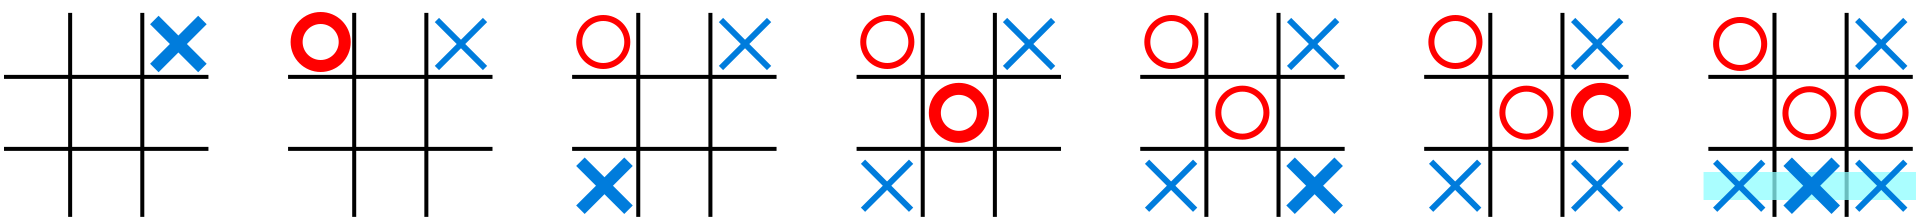

Tic-tac-toe is a solved game. This means that if both players always discover the best play, the game is a forced draw.

### MENACE

MENACE was initially intended to be a system of matchboxes, where each matchbox represents a possible state of tic-tac-toe.

At the start, each matchbox is filled with an equal number of coloured beads, where each colour represents the choice of MENACE's next action. The earlier the game state, the more beads each state starts off with.

Every time when it is MENACE's turn to play, MENACE first finds the matchbox that matches the current state of the board. Then, the matchbox is opened, and a single bead is randomly selected from the matchbox. The colour of the bead corresponds to the action of which MENACE would play, i.e. which grid MENACE would place its symbol. The matchboxes opened and the beads selected are set aside to be recorded until the game ends. This process repeats from start to finish for every game played.

If MENACE wins in a game, it receives a reward for its victory by returning the drawn beads and adding three additional similar coloured beads into all the matchboxes that were used in a single game. This increases the probability of MENACE selecting those beads given the state.

If the game ends in a draw, MENACE also receives a reward by returning the drawn beads and adding one additional similar coloured beads into all the matchboxes that were used (A draw is rewarded because the best play between both players will result in a forced draw). This increases the probability of MENACE selecting those beads given the state.

If MENACE loses, it receives a punishment by removing the drawn beads completely. This decreases the probability of MENACE selecting those beads given the state.

To train MENACE, the game is played repeatedly.

If the game reaches a state where there are no more beads left in the matchbox, MENACE resigns, and the game is considered a lost for MENACE.

Overtime, MENACE will learn to select beads that will lead to either a win or a draw, and avoid beads that will lead to a loss, given each state.

## Importing the libraries

In [12]:
from collections import Counter
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer
import pickle
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set_style("darkgrid")

## Tic-tac-toe boards

### 3x3 board, 3 in a row to win

First, we define the class `Board3`<sup>2</sup> to represent a 3 x 3 tic-tac-toe game board.

- `__init__(self)` initialises the board by creating an empty list of 9 spaces.
- `__str__(self)` returns a string representation of the board in the form of a tic-tac-toe grid, with the current state of the board filled in.
- `valid_move(self, move)` validates if the move made by the player is valid or not by returning `True` if the move is valid, i.e. an integer between 0-8 and the corresponding position on the board is not already occupied, and `False` otherwise.
- `winning(self)` checks if there is a winner in the game by returning `True`, and `False` otherwise.
- `draw(self)` checks if the game is a draw by returning `True`, and `False` otherwise.
- `play_move(self, position, marker)` assigns `marker` to the `position` on the board.
- `board_string(self)` returns the current state of the board as a string.

In [13]:
class Board3:
    def __init__(self):
        self.board = [' '] * 9

    def __str__(self):
        return("\n 0 | 1 | 2     %s | %s | %s\n"
               "---+---+---   ---+---+---\n"
               " 3 | 4 | 5     %s | %s | %s\n"
               "---+---+---   ---+---+---\n"
               " 6 | 7 | 8     %s | %s | %s" % (self.board[0], self.board[1], self.board[2],
                                                self.board[3], self.board[4], self.board[5],
                                                self.board[6], self.board[7], self.board[8]))

    def valid_move(self, move):
        try:
            move = int(move)
        except ValueError:
            return False
        if 0 <= move <= 8 and self.board[move] == ' ':
            return True
        return False

    def winning(self):
        return ((self.board[0] != ' ' and
                 ((self.board[0] == self.board[1] == self.board[2]) or
                  (self.board[0] == self.board[3] == self.board[6]) or
                  (self.board[0] == self.board[4] == self.board[8])))
                or (self.board[4] != ' ' and
                    ((self.board[1] == self.board[4] == self.board[7]) or
                    (self.board[3] == self.board[4] == self.board[5]) or
                    (self.board[2] == self.board[4] == self.board[6])))
                or (self.board[8] != ' ' and
                    ((self.board[2] == self.board[5] == self.board[8]) or
                    (self.board[6] == self.board[7] == self.board[8]))))

    def draw(self):
        return all((x != ' ' for x in self.board))

    def play_move(self, position, marker):
        self.board[position] = marker

    def board_string(self):
        return ''.join(self.board)

### 4x4 board, 4 in a row to win

Similarly, we define the class `Board4` to represent a 4 x 4 tic-tac-toe game board.

In [14]:
class Board4:
    def __init__(self):
        self.board = [' '] * 16

    def __str__(self):
        return("\n  0 |  1 |  2 |  3      %s |  %s |  %s |  %s\n"
               "----+----+----+----   ----+----+----+----\n"
               "  4 |  5 |  6 |  7      %s |  %s |  %s |  %s\n"
               "----+----+----+----   ----+----+----+----\n"
               "  8 |  9 | 10 | 11      %s |  %s |  %s |  %s\n"
               "----+----+----+----   ----+----+----+----\n"
               " 12 | 13 | 14 | 15      %s |  %s |  %s |  %s" % (self.board[0], self.board[1], self.board[2], self.board[3],
                                                                 self.board[4], self.board[5], self.board[6], self.board[7],
                                                                 self.board[8], self.board[9], self.board[10], self.board[11],
                                                                 self.board[12], self.board[13], self.board[14], self.board[15]))

    def valid_move(self, move):
        try:
            move = int(move)
        except ValueError:
            return False
        if 0 <= move <= 15 and self.board[move] == ' ':
            return True
        return False

    def winning(self):
        return ((self.board[0] != ' ' and
                 ((self.board[0] == self.board[1] == self.board[2] == self.board[3]) or
                  (self.board[0] == self.board[4] == self.board[8] == self.board[12]) or
                  (self.board[0] == self.board[5] == self.board[10] == self.board[15])))
                or (self.board[6] != ' ' and
                    ((self.board[3] == self.board[6] == self.board[9] == self.board[12]) or
                    (self.board[4] == self.board[5] == self.board[6] == self.board[7]) or
                    (self.board[2] == self.board[6] == self.board[10] == self.board[14])))
                or (self.board[9] != ' ' and
                    ((self.board[1] == self.board[5] == self.board[9] == self.board[13]) or
                    (self.board[8] == self.board[9] == self.board[10] == self.board[11])))
                or (self.board[15] != ' ' and
                    ((self.board[3] == self.board[7] == self.board[11] == self.board[15]) or
                    (self.board[12] == self.board[13] == self.board[14] == self.board[15]))))

    def draw(self):
        return all((x != ' ' for x in self.board))

    def play_move(self, position, marker):
        self.board[position] = marker

    def board_string(self):
        return ''.join(self.board)

## MENACE

### MenacePlayer

We define the class `MenacePlayer`<sup>2</sup> that adopts Donald Michie's MENACE.

- `__init__(self)` initialises the `MenacePlayer` object, where
    - `self.matchboxes` is a dictionary that maps the game board states to a list of beads, representing the moves that `MenacePlayer` can make from that board state,
    - `self.num_win`, `self.num_draw`, `self.num_lose` represent the number of wins, draws, and losses `MenacePlayer` has made,
    - `self.net_win` is the net number of wins `MenacePlayer` has made, where a win contributes `+1`, a loss contributes `-1`, and a draw makes no changes,
    - `self.history` records the accumulation of the net number of wins MenacePlayer has made after each game.
- `start_game(self)` is called at the start of each game to reset the `self.moves_played` of MenacePlayer.
- `get_move(self, board)` looks up the board state in the `self.matchboxes` dictionary and chooses a move (bead) at random from the list of available moves (beads), and resigns if there are no available moves (beads) left.
- `win_game(self)` is called when `MenacePlayer` wins the game. It adds three additional copies of each bead used in the game to the corresponding matchboxes, updates the win statistics, and updates the history of net wins.
- `draw_game(self)` is called when `MenacePlayer` draws the game. It adds one additional copy of each bead used in the game to the corresponding matchboxes, updates the draw statistics, and updates the history of net wins.
- `lose_game(self)` is called when `MenacePlayer` loses the game. It removes one instance of each bead used in the game from the corresponding matchboxes, updates the loss statistics, and updates the history of net wins.
- `print_stats(self)` prints the statistics for `MenacePlayer`'s gameplay, including the number of boards it has learned, and the number of games it has won, drawn, and lost.
- `print_probability(self, board)` prints the probability distribution of beads for the corresponding board state in the `self.matchboxes` dictionary.

In [90]:
class MenacePlayer:
    def __init__(self):
        self.matchboxes = {}
        self.num_win = 0
        self.num_draw = 0
        self.num_lose = 0
        self.net_win = 0
        self.history = [0]

    def start_game(self):
        self.moves_played = []

    def get_move(self, board):
        # Find board in matchboxes and choose a bead
        # If the matchbox is empty, return -1 (resign)
        board = board.board_string()
        if board not in self.matchboxes:
            new_beads = [pos for pos, mark in enumerate(board) if mark == ' ']
            # Early boards start with more beads
            self.matchboxes[board] = new_beads * ((len(new_beads) + 2) // 2)

        beads = self.matchboxes[board]
        if len(beads):
            bead = random.choice(beads)
            self.moves_played.append((board, bead))
        else:
            bead = -1
        return bead

    def win_game(self):
        # We won, add three beads
        for (board, bead) in self.moves_played:
            self.matchboxes[board].extend([bead, bead, bead])
        self.num_win += 1
        self.net_win += 1
        self.history.append(self.net_win)

    def draw_game(self):
        # A draw, add one bead
        for (board, bead) in self.moves_played:
            self.matchboxes[board].append(bead)
        self.num_draw += 1
        self.net_win += 0
        self.history.append(self.net_win)

    def lose_game(self):
        # Lose, remove a bead
        for (board, bead) in self.moves_played:
            matchbox = self.matchboxes[board]
            del matchbox[matchbox.index(bead)]
        self.num_lose += 1
        self.net_win -= 1
        self.history.append(self.net_win)

    def print_stats(self):
        print('Have learnt %d boards' % len(self.matchboxes))
        print('W/D/L: %d/%d/%d' % (self.num_win, self.num_draw, self.num_lose))

    def print_probability(self, board):
        board = board.board_string()
        try:
            print("Stats for this board: " +
                  str(Counter(self.matchboxes[board]).most_common()))
        except KeyError:
            print("Never seen this board before.")

### HumanPlayer

We define a class `HumanPlayer`<sup>2</sup> so that we are able to interact with `MenacePlayer` and other machine players below.

In [91]:
class HumanPlayer:
    def __init__(self):
        pass

    def start_game(self):
        print("Get ready!")

    def get_move(self, board):
        while True:
            move = input('Make a move: ')
            if board.valid_move(move):
                break
            print("Not a valid move")
        return int(move)

    def win_game(self):
        print("You won!")

    def draw_game(self):
        print("It's a draw.")

    def lose_game(self):
        print("You lose.")

    def print_probability(self, board):
        pass

### Function to play the game

We define the function `play_game`<sup>2</sup> to simulate a game between two players.
- The function creates a `Board3` or `Board4` object depending on which board is specified in the `game` argument.
- `start_game()` is called on each player object to initialise them for the game.
- If `silent` is `False`, each message and each state of the board is printed per round. `silent` is only set to `True` when training multiple games between two non-human players.
- The game is played in a while loop that continues until either a player wins or the game ends in a draw or the player resigns (HumanPlayer has no option to resign).
- `print_probability()` is called on the first player object to print the probability distribution of beads for the current board state.
- `get_move()` is then called on the first player object to obtain their move. If the move is `-1`, the first player resigns, and the game ends with a loss for the first player and a win for the second player.
- Otherwise, `play_move()` is called on the board. If the move results in a win for the first player, the game ends with a win for the first player and a loss for the second player, and similarly for a draw.
- This repeats for the second player object.
- Both player objects repeat for each turn until the game ends in a win/lose condition or a draw condition.

In [92]:
def play_game(game, first, second, silent = False):
    
    if game == 'board3':
        board = Board3()
        
    elif game == 'board4':
        board = Board4()
    
    else:
        raise ValueError("Valid inputs are 'board3', 'board4'")
        
    first.start_game()
    second.start_game()

    if not silent:
        print("\n\nStarting a new game!")
        print(board)
    
    while True:
        if not silent:
            first.print_probability(board)
        move = first.get_move(board)
        if move == -1:
            if not silent:
                print("Player resigns")
            first.lose_game()
            second.win_game()
            break
        board.play_move(move, 'X')
        if not silent:
            print(board)
        if board.winning():
            first.win_game()
            second.lose_game()
            break
        if board.draw():
            first.draw_game()
            second.draw_game()
            break

        if not silent:
            second.print_probability(board)
        move = second.get_move(board)
        if move == -1:
            if not silent:
                print("Player resigns")
            second.lose_game()
            first.win_game()
            break
        board.play_move(move, 'O')
        if not silent:
            print(board)
        if board.winning():
            second.win_game()
            first.lose_game()
            break
        if board.draw():
            first.draw_game()
            second.draw_game()
            break

### Function to train MenacePlayer 1 and MenacePlayer 2

In Donald Michie's MENACE experiment, he treated MENACE as a first player object, and himself as the second player object. He then played MENACE for over 200 games, where MENACE drew consistently after 20 games. Donald Michie tried to include some randomness into his gameplay against MENACE and was able to defeat MENACE, but MENACE quickly learned to stop losing.

In this project, we aim to create and train two separate MENACE objects, each representing Player 1 and Player 2, by creating a function `train_menace` to run multiple games between these two player objects and train them.

- The function starts by initialising `menace1` and `menace2` as initial `MenacePlayer` each.
- The training is a for loop where the function `play_game` is executed a number of times depending on the number of `games`.
- The `silent` argument is `True` to avoid printing each output of each game.
- After both `MenacePlayer` are trained, the function prints the statistics for both `MenacePlayer`, including the number of games played, the number of wins, draws, and losses, and the net number of wins.
- The function also then plots the net number of wins over each game for each `MenacePlayer`.
- The plots should be symmetrical at the x-axis.
- Then, the function prints the time taken for training.
- Finally, the function returns the trained `MenacePlayer` objects.

However, due to probability, there is a chance where one of the MenacePlayers signficantly underperforms the other by consistently making randomly selected poor choices. This may lead the MenacePlayer to run out of beads in the earlier matchboxes and resigns constantly. This obviously is not optimal.

Another scenario is where one of the MenacePlayers significantly outperforms the other by consistently making randomly selected excellent choices. This may lead the MenacePlayer to have a higher proportion of wins than draws. This is not optimal because an optimal game always leads to a forced draw.

Suppose in a single game of tic tac toe, where both players randomly select a move. Using Marcello Cammarata's solution<sup>3</sup>, the game ends with
- Player 1 winning with a probability of `0.584850`,
- Player 2 winning with a probability of `0.288275`,
- a draw with a probability of `0.126875`.

Therefore, naturally, Player 1 should be winning more than Player 2.

With all that, we introduce new arguments into the existing `train_menace` function.

- We first introduce two draw requirements.
    - The number of draws should be more than the number of wins, which should be more than the number of losses, all made by `MenacePlayer` 1.
    - The proportion of draws should be higher than an arbitrarily set `draw_threshold`.
- The argument `draw_reqs` essentially is an argument whether if we want the `MenacePlayer` objects to be trained optimally.
- If `draw_reqs` is `False`, `train_menace` ignores the possibility of suboptimal training (i.e. ignores the draw requirements) and attempts the training only once.
- Otherwise, if `train_menace` fails to train the `MenacePlayer` objects optimally by meeting the draw requirements, `train_menace` will attempt training again by starting the process all over until it does.
- Each attempt increases the number of trials in `num_trials`.
- If `num_trials` equals `max_trials`, `train_menace` breaks the while loop and stops training.

In [93]:
def train_menace(game, games, draw_reqs = True, draw_threshold = 0.7, max_trials = 100):
    start = timer()
    trained = False
    num_trials = 0
    
    while not trained:
        menace1 = MenacePlayer()
        menace2 = MenacePlayer()
        
        for _ in tqdm(range(games)):
            play_game(game, menace1, menace2, silent = True)
            
        num_trials += 1
        
        if draw_reqs == True:
            if (menace1.num_draw > menace1.num_win > menace1.num_lose) & ((menace1.num_draw / games) >= draw_threshold):
                trained = True
            else:
                trained = False
                
                if num_trials == max_trials:
                    print('Unable to train Menace with the draw requirements.')
                    print('Try again with more games or a higher max_trials or a lower draw_threshold.')
                    end = timer()
                    print('{} seconds elapsed.'.format(end - start))
                    break
        
        else:
            trained = True
        
    if trained == True:
        print('Menace is trained')
        print('------------------------------')
        print('Number of games = {}'.format(games))
        print('Number of trials = {}'.format(num_trials))
        print('------------------------------')
        print('Menace1:')
        menace1.print_stats()
        print('Proportion of wins = {}'.format(menace1.num_win / games))
        print('Proportion of draws = {}'.format(menace1.num_draw / games))
        print('Proportion of losses = {}'.format(menace1.num_lose / games))
        print('------------------------------')
        print('Menace2:')
        menace2.print_stats()
        print('Proportion of wins = {}'.format(menace2.num_win / games))
        print('Proportion of draws = {}'.format(menace2.num_draw / games))
        print('Proportion of losses = {}'.format(menace2.num_lose / games))
        
        fig, ax = plt.subplots(2, figsize = (15, 10))
        ax[0].plot(menace1.history)
        ax[0].axhline(y = 0, color = 'r', linestyle = '--')
        ax[0].set_title('Menace1')
        ax[0].set_xlabel('Number of games')
        ax[0].set_ylabel('Net number of wins')
        ax[1].plot(menace2.history)
        ax[1].axhline(y = 0, color = 'r', linestyle = '--')
        ax[1].set_title('Menace2')
        ax[1].set_xlabel('Number of games')
        ax[1].set_ylabel('Net number of wins');
        plt.show()
        
        end = timer()
        print('{} seconds elapsed.'.format(end - start))
        
        return menace1, menace2

## Training MENACE

### 3x3 board

#### Training for 100 games, draw_reqs = False

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33439.40it/s]


Menace is trained
------------------------------
Number of games = 100
Number of trials = 1
------------------------------
Menace1:
Have learnt 254 boards
W/D/L: 58/12/30
Proportion of wins = 0.58
Proportion of draws = 0.12
Proportion of losses = 0.3
------------------------------
Menace2:
Have learnt 223 boards
W/D/L: 30/12/58
Proportion of wins = 0.3
Proportion of draws = 0.12
Proportion of losses = 0.58


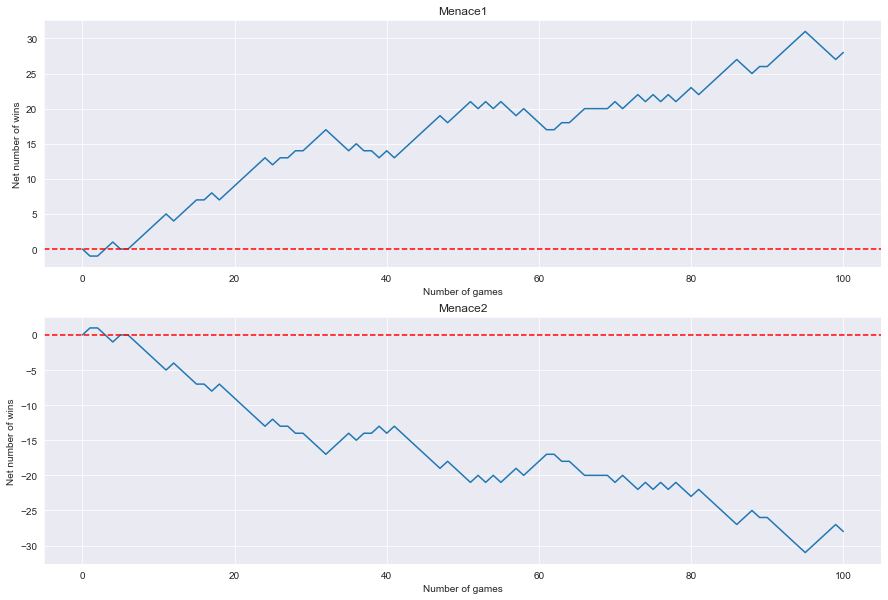

0.26323150000098394 seconds elapsed.


(<__main__.MenacePlayer at 0x1ec75213f70>,
 <__main__.MenacePlayer at 0x1ec75a8a970>)

In [34]:
train_menace('board3', 100, draw_reqs = False)

By playing only `100` games, we can see that the `W/D/L` statistic is similar to the probability distribution of both players randomly selecting a move above. Therefore, training `MenacePlayer` for `100` games is far from optimal.

#### Training for 10,000 games, draw_reqs = False

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32665.77it/s]


Menace is trained
------------------------------
Number of games = 10000
Number of trials = 1
------------------------------
Menace1:
Have learnt 2167 boards
W/D/L: 4133/3668/2199
Proportion of wins = 0.4133
Proportion of draws = 0.3668
Proportion of losses = 0.2199
------------------------------
Menace2:
Have learnt 1881 boards
W/D/L: 2199/3668/4133
Proportion of wins = 0.2199
Proportion of draws = 0.3668
Proportion of losses = 0.4133


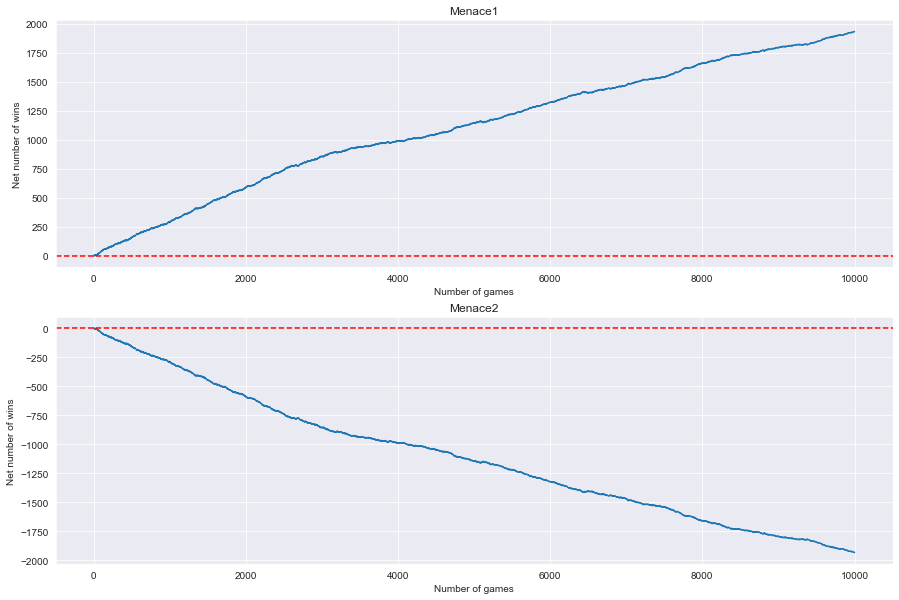

0.5745539000017743 seconds elapsed.


(<__main__.MenacePlayer at 0x1ec74f8e940>,
 <__main__.MenacePlayer at 0x1ec74f8e370>)

In [47]:
train_menace('board3', 10000, draw_reqs = False)

Training for `10,000` games sees an increase in the proportion of draws, drawing the game about a third of the time.

#### Training for 100,000 games, draw_reqs = False

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 56105.27it/s]


Menace is trained
------------------------------
Number of games = 100000
Number of trials = 1
------------------------------
Menace1:
Have learnt 2364 boards
W/D/L: 61325/32702/5973
Proportion of wins = 0.61325
Proportion of draws = 0.32702
Proportion of losses = 0.05973
------------------------------
Menace2:
Have learnt 2016 boards
W/D/L: 5973/32702/61325
Proportion of wins = 0.05973
Proportion of draws = 0.32702
Proportion of losses = 0.61325


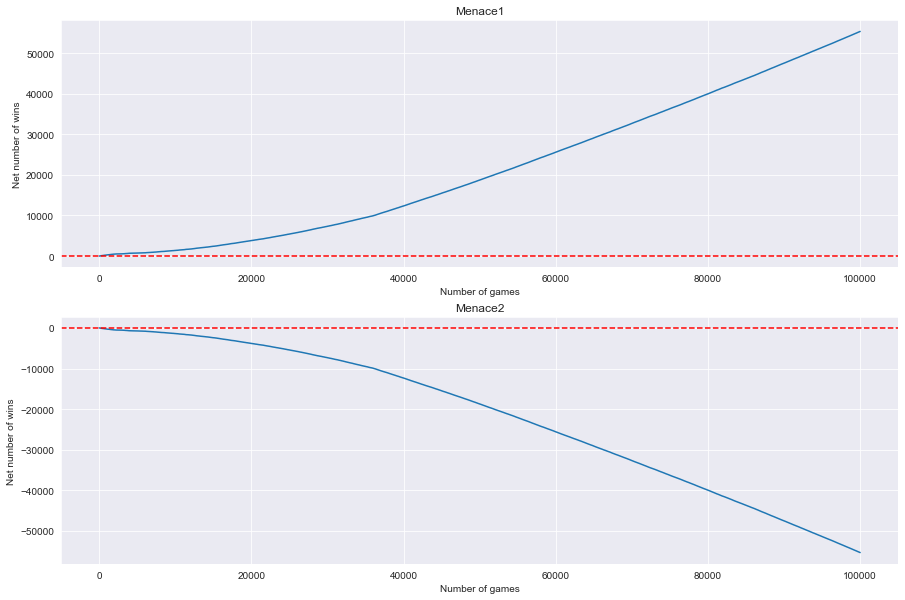

2.07226079999964 seconds elapsed.


(<__main__.MenacePlayer at 0x1ec75af82e0>,
 <__main__.MenacePlayer at 0x1ec77d4cc40>)

In [51]:
train_menace('board3', 100000, draw_reqs = False)

In this specific example, after training for `100,000` games, we can see that the proportion of draws actually decreased from `10,000` games. This is because of random probability explained previously where `Menace1` has consistently but randomly made excellent choices while `Menace2` has consistently but randomly made poor choices. This lead to `Menace1` outperforming itself, winning most games against `Menace2`. As we can see the graphs past `40,000` games, the graph appears linear. Therefore, they are not optimally trained, and we can now enforce the draw requirements to the training.

#### Training for 100,000 games, draw_reqs = True

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31697.29it/s]


Menace is trained
------------------------------
Number of games = 100000
Number of trials = 2
------------------------------
Menace1:
Have learnt 2409 boards
W/D/L: 13510/78901/7589
Proportion of wins = 0.1351
Proportion of draws = 0.78901
Proportion of losses = 0.07589
------------------------------
Menace2:
Have learnt 2085 boards
W/D/L: 7589/78901/13510
Proportion of wins = 0.07589
Proportion of draws = 0.78901
Proportion of losses = 0.1351


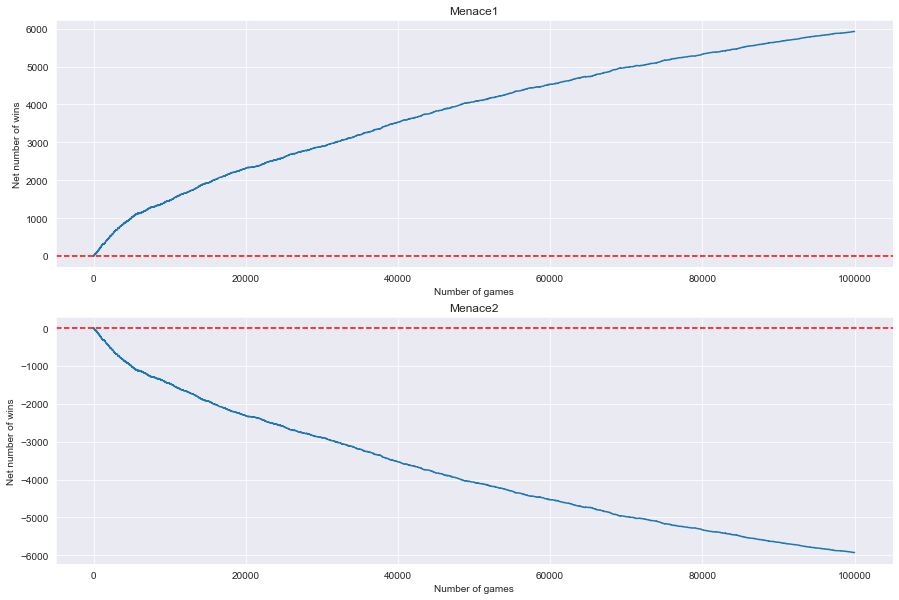

5.076241700000537 seconds elapsed.


(<__main__.MenacePlayer at 0x1ec75af8970>,
 <__main__.MenacePlayer at 0x1ec74fb92b0>)

In [54]:
train_menace('board3', 100000, draw_reqs = True, draw_threshold = 0.7)

This time, in this specific instance, the `train_menace` function had to attempt the training twice such that the draw requirements are met.

Now, both `Menace1` and `Menace2` draw consistently about three quarters of the time, which is a significant improvement.

Comparing the graphs between training `100,000` games with `draw_reqs = False` and `draw_reqs = True`, we can see that latter graphs are more concave compared the former. This is because a draw constitutes no changes in the net number of wins.

#### Training for 1,000,000 games, draw_reqs = True

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:35<00:00, 27897.45it/s]


Menace is trained
------------------------------
Number of games = 1000000
Number of trials = 3
------------------------------
Menace1:
Have learnt 2402 boards
W/D/L: 28744/958863/12393
Proportion of wins = 0.028744
Proportion of draws = 0.958863
Proportion of losses = 0.012393
------------------------------
Menace2:
Have learnt 2072 boards
W/D/L: 12393/958863/28744
Proportion of wins = 0.012393
Proportion of draws = 0.958863
Proportion of losses = 0.028744


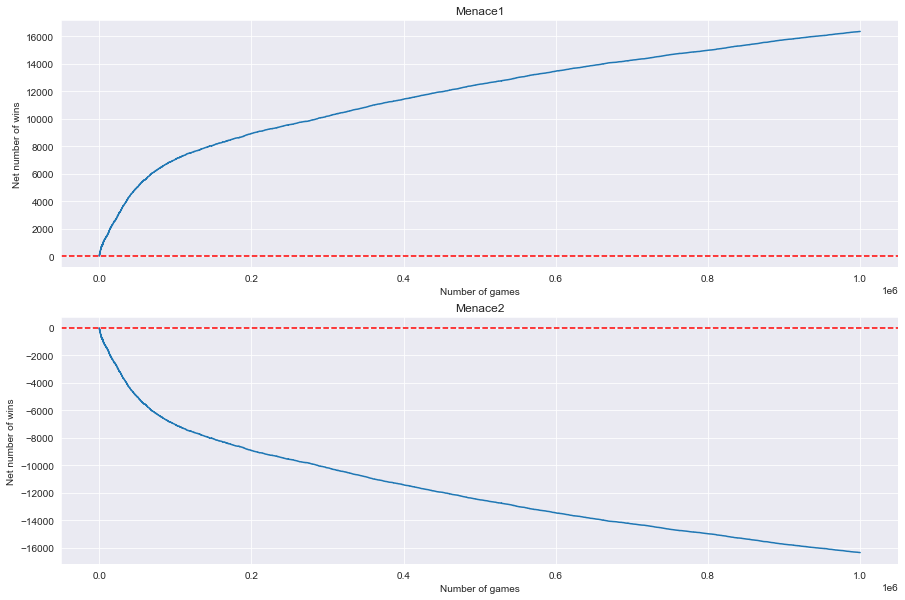

52.788077500001236 seconds elapsed.


(<__main__.MenacePlayer at 0x1ec726c62e0>,
 <__main__.MenacePlayer at 0x1ec75edb2b0>)

In [56]:
train_menace('board3', 1000000, draw_reqs = True, draw_threshold = 0.9)

By optimally training for `1,000,000` games, we can see that both `Menace1` and `Menace2` have reached about a `95%` draw rate.

Training optimally for `1,000,000` games takes roughly a minute.

We can do even better by increasing to a higher magnitude.

#### Training for 10,000,000 games, draw_reqs = True

This time, we now save the trained `MenacePlayer` objects so that we as the `HumanPlayer` can play it after training as `board3_menace1` and `board3_menace2` respectively. We also force `train_menace` to have a `draw_threshold` of `0.99`.

100%|████████████████████████████| 10000000/10000000 [04:37<00:00, 35979.54it/s]


Menace is trained
------------------------------
Number of games = 10000000
Number of trials = 1
------------------------------
Menace1:
Have learnt 2415 boards
W/D/L: 42959/9945340/11701
Proportion of wins = 0.0042959
Proportion of draws = 0.994534
Proportion of losses = 0.0011701
------------------------------
Menace2:
Have learnt 2092 boards
W/D/L: 11701/9945340/42959
Proportion of wins = 0.0011701
Proportion of draws = 0.994534
Proportion of losses = 0.0042959


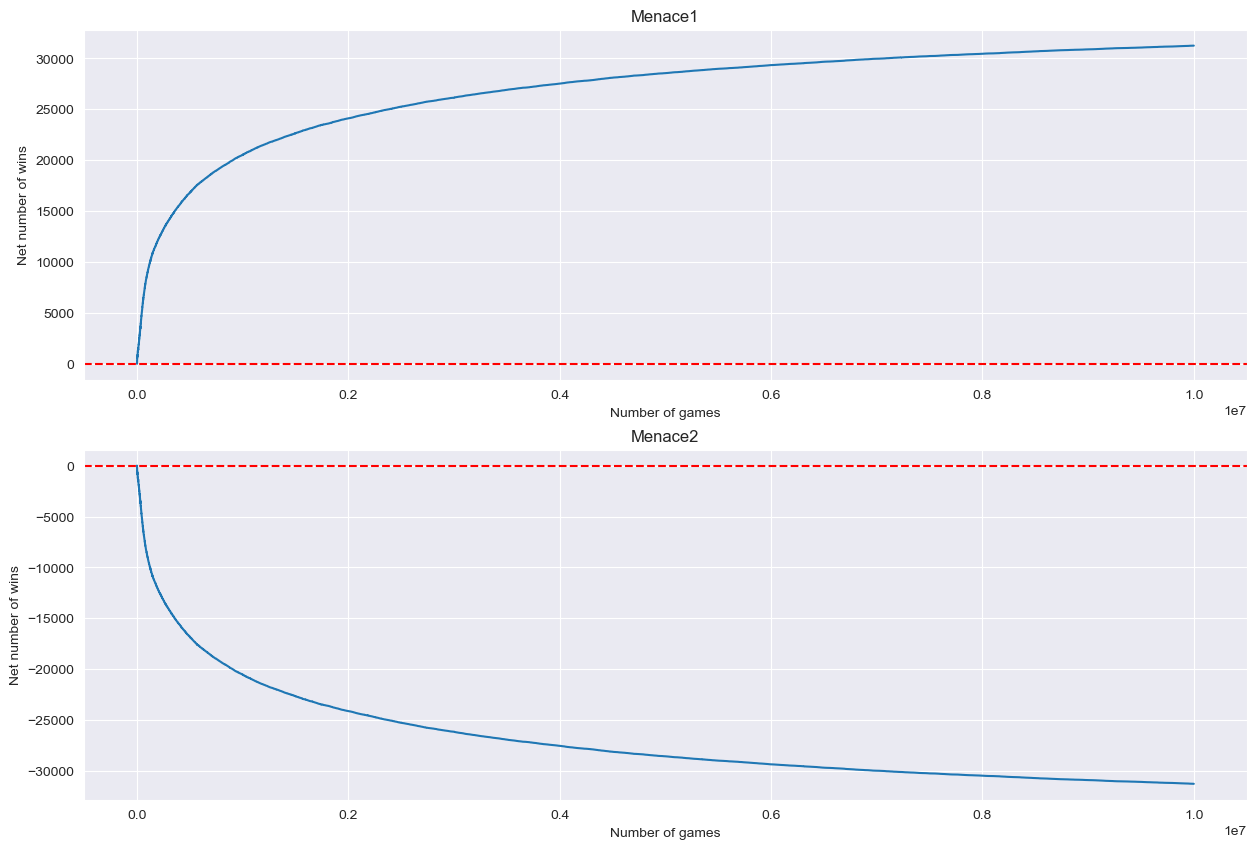

282.529251292 seconds elapsed.


In [7]:
board3_menace1, board3_menace2 = train_menace('board3', 10000000, draw_reqs = True, draw_threshold = 0.99)

Now, `board3_menace1` and `board3_menace2` have a draw rates of about `99.5%`, with their win rates at about `0.4%` and `0.1%` respectively, which are highly optimal.

Training for `10,000,000` games takes about 5 minutes.

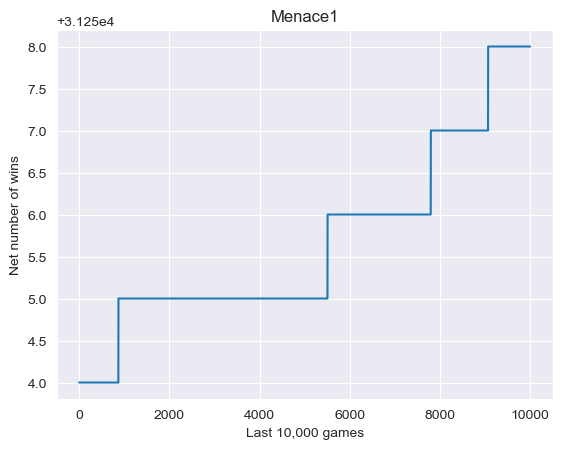

In [8]:
plt.plot(board3_menace1.history[-10000:])
plt.title('Menace1')
plt.xlabel('Last 10,000 games')
plt.ylabel('Net number of wins');

The above plot shows the last 10,000 games of `board3_menace1`. We can see that over the course of the last 10,000 games, there were 4 changes in the net number of wins. Despite having around a `99.5%` draw rate, it is still winning and losing, i.e., it is still learning.

We could continue further the training by increasing the magnitude of games played. However, training for `100,000,000` games takes about an hour, and it is not worth training it timewise, just for less than a percentage increase in the draw rate.

##### board3_menace1 vs human

In [95]:
play_game('board3', board3_menace1, HumanPlayer())

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Stats for this board: [(4, 3187236), (2, 1412184), (6, 1383333), (0, 1068733), (8, 815972), (1, 807026), (5, 668323), (7, 531892), (3, 179138)]

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 0

 0 | 1 | 2     O |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Stats for this board: [(2, 17), (1, 16), (5, 7), (6, 4), (7, 4), (8, 4), (3, 3)]

 0 | 1 | 2     O | X |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 7

 0 | 1 | 2     O | X |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       | O |  
Stats for this board: [(6, 56271), (3, 32057), (5, 25310), (8, 1755), (

`board3_menace1` played optimally, ending the game in a forced draw.

Interestingly, `board3_menace1` has learned its starting move such that
- it has the highest probability to start in the centre (4),
- followed by starting at the corners (2, 6, 0, 8),
- followed by starting at the sides (1, 5, 7, 3).

In [98]:
# calculating the percentage that board3_menace1 plays at position 2 at move 5
2 / (56271 + 32057 + 25310 + 1755 + 2) * 100

0.0017331773473720697

In move 5 (`board3_menace1`'s 3rd move), there are only 2 beads left to play for position `2`, i.e. about a `0.0017%` chance that it will play position `2` at move 5.

`board3_menace1` has learned to avoid playing position `2` at move 5 because it creates a winning position for Player 2 by playing position `6` at move 6, creating potential three in a rows in positions `0, 3, 6` and `6, 7, 8`.

##### human vs board3_menace2

In [96]:
play_game('board3', HumanPlayer(), board3_menace2)

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 0

 0 | 1 | 2     X |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Stats for this board: [(4, 1062317), (2, 84), (1, 17), (6, 12), (7, 9), (5, 1)]

 0 | 1 | 2     X |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 2

 0 | 1 | 2     X |   | X
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Stats for this board: [(1, 392752), (3, 4), (5, 3)]

 0 | 1 | 2     X | O | X
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 7

 0 | 1 | 2     X | O | X
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8       | X |  
Stats for this board:

`board3_menace2` played optimally, ending the game in a forced draw.

`board3_menace2` has learned to mostly play in the middle (position `4`) if Player 1's starting move is the corner.

In [99]:
# calculating the percentage that board3_menace2 plays at position 1 at move 4
392752 / (392752 + 3 + 7) * 100

99.9974539288424

In move 4 (`board3_menace2`'s 2nd move), it has learned to block Player 1's potential three in a row by playing position `1`, `99.997%` of the time, which is almost perfectly optimal.

In move 8 (`board3_menace2`'s 4th move), it has learned to always block Player 1's potential three in a row by always playing position `6`. There are no more beads left for the option to play position `5`. Specifically in this state of the board, `board3_menace2` has learned to optimally respond.

### 4x4 board

#### Training for 1,000,000 games, draw_reqs = True

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [04:20<00:00, 3839.71it/s]


Menace is trained
------------------------------
Number of games = 1000000
Number of trials = 1
------------------------------
Menace1:
Have learnt 2248656 boards
W/D/L: 325525/434830/239645
Proportion of wins = 0.325525
Proportion of draws = 0.43483
Proportion of losses = 0.239645
------------------------------
Menace2:
Have learnt 2183413 boards
W/D/L: 239645/434830/325525
Proportion of wins = 0.239645
Proportion of draws = 0.43483
Proportion of losses = 0.325525


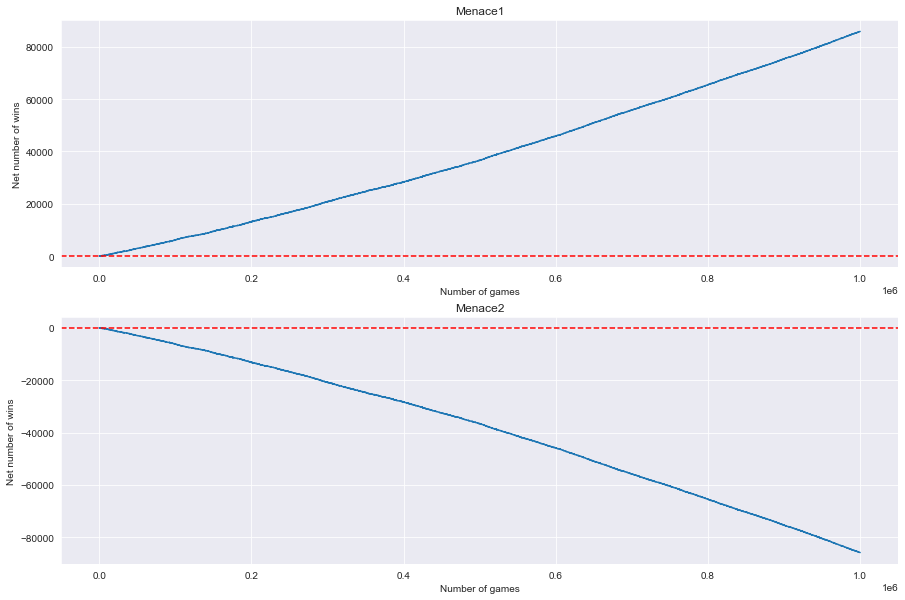

263.2450358 seconds elapsed.


(<__main__.MenacePlayer at 0x1d79550ca60>,
 <__main__.MenacePlayer at 0x1d79550c0d0>)

In [8]:
train_menace('board4', 1000000, draw_reqs = True, draw_threshold = 0.4)

A 4x4 board has 16 positions, almost double of a 3x3 board which has 9 positions. Therefore, each game requires more time to complete, and a 4x4 board requires more games to be optimally trained.

Training for `1,000,000` games only resulted in about a `43%` draw rate, which is still far from optimal. Training time for this takes about 5 minutes.

Comparing this to the 3x3 board with `1,000,000` games, the 3x3 board resulted in a `95%` draw rate, trained around a minute.

#### Training for 50,000,000 games, draw_reqs = True (DO NOT RUN)

100%|███████████████████████████| 50000000/50000000 [22:47:56<00:00, 609.19it/s]


Menace is trained
------------------------------
Number of games = 50000000
Number of trials = 1
------------------------------
Menace1:
Have learnt 4651809 boards
W/D/L: 10063797/31764601/8171602
Proportion of wins = 0.20127594
Proportion of draws = 0.63529202
Proportion of losses = 0.16343204
------------------------------
Menace2:
Have learnt 4401695 boards
W/D/L: 8171602/31764601/10063797
Proportion of wins = 0.16343204
Proportion of draws = 0.63529202
Proportion of losses = 0.20127594


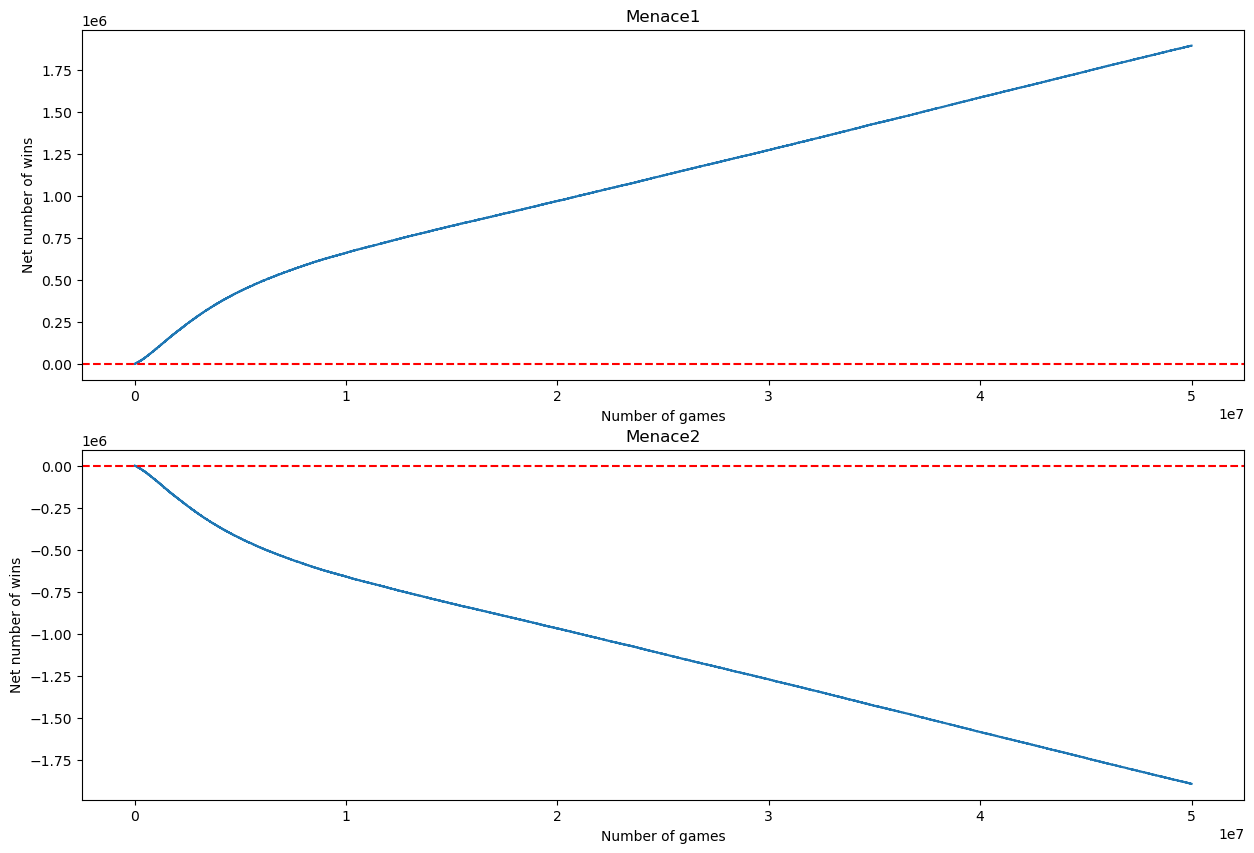

82138.954186458 seconds elapsed.


In [11]:
board4_menace1, board4_menace2 = train_menace('board4', 50000000, draw_reqs = True, draw_threshold = 0.6)

Training for `50,000,000` games resulted in only about a `64%` draw rate, which is still far from optimal. Training this took just under 24 hours.

We have decided that though it is technically posible to train a 4x4 board optimally, it is not worth the time, considering that we only achieved `64%` after slightly less than 24 hours. A stronger computing power and more time is needed in order to continue on.

##### board4_menace1 vs human

In [15]:
play_game('board4', board4_menace1, HumanPlayer())

Get ready!


Starting a new game!

  0 |  1 |  2 |  3        |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Stats for this board: [(6, 8330444), (3, 6943395), (10, 6616792), (12, 6108777), (0, 4942262), (5, 4347442), (9, 4176094), (13, 2095273), (1, 1977371), (15, 1970559), (2, 1773400), (8, 1686984), (14, 1059172), (4, 742478), (7, 621976), (11, 392122)]

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 5

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |  O |   

In [12]:
# calculating the percentage that board4_menace1 plays at position 4 at move 7
604 / (604 + 23 + 22 + 18 + 10 + 9 + 9 + 9 + 4 + 1) * 100

85.1904090267983

At move 7 (`board4_menace1`'s 4th move), it has learned to block a potential four in a row by playing position `4`, about `85%` of the time.

In [17]:
# calculating the percentage that board4_menace1 plays at position 11 at move 13
8 / (102 + 26 + 17 + 8) * 100

5.228758169934641

In [15]:
# calculating the percentage that board4_menace1 plays at position 13 at move 13
102 / (102 + 26 + 17 + 8) * 100

66.66666666666666

In [16]:
# calculating the percentage that board4_menace1 plays at position 13 at move 15
68 / (68 + 15) * 100

81.92771084337349

At move 12 (`HumanPlayer()`'s 6th move), we intentionally did not block `board4_menace1`'s potential four in a row by playing position `13`.

However, `board4_menace1` did not respond by playing position `13`, and played position `11` instead, with about a `5%` chance in doing so. `board4_menace1` had about a `67%` chance in correctly playing position `13`, but didn't.

Subsequently, after still intentionally not blocking `board4_menace1`'s win again, `board4_menace1` finally played position `13` at move 15 with about a `85%` chance, winning the game.

These supposed 'confirm wins' with only `67%` and `85%` chance choosing those positions are still low and far from optimal, and requires more games to train.

## SARSA 

*SARSA* is an on-policy, model-free reinforcement learning algorithm. It expands to *“State Action Reward State Action”*, symbolising the tuple ($\textbf{s}$, $\textbf{a}$, $\textbf{r}$, $\textbf{s'}$,$\textbf{a'}$). This algorithm seeks to find the best course of action by finding the optimal action-selection policy in a *Markov Decision Process* (MDP). 

*SARSA* iteratively updates an estimate of the Q-function, *Q(**s**,**a**)*, which is the expected cumulative reward received when taking an action **a** in a state **s**. We can break this down. 

First, we can write the Bellman equation for the (state) value function as:

$$ V^{\pi}(\textbf{s})=\mathbb{E}[r+\gamma V^{\pi}(\textbf{s'})]$$

Based on the (state) value function, the Bellman equation for the state-action value function is written as:

$$ Q^{\pi}(\textbf{s},\textbf{a})=\mathbb{E}^{\pi}[r+\gamma Q^{\pi}(\textbf{s'},\textbf{a'})]$$

Finally, by transferring the formula above, we obtain the incremental estimation of the state-action value function (to be updated iteratively):

$$Q(\textbf{s},\textbf{a})\leftarrow Q(\textbf{s},\textbf{a})+\alpha[r+\gamma Q(\textbf{s'},\textbf{a'})-Q(\textbf{s},\textbf{a})]$$

Where:
-	$r$ is the immediate reward
-	$\alpha$ is the learning rate
-	$\gamma$ is the discount factor
-	$\textbf{a’}$ is the next action
-	$\textbf{s’}$ is the next state

Note that $\textbf{s'}$ is a non-terminal state. If $\textbf{s'}$ is a terminal state, $Q(\textbf{s'},\textbf{a'})=0$.

### SARSAPlayer

We create an extended subclass to the original `MenacePlayer` called `SARSAPlayer` that uses the SARSA algorithm to learn from its experience during the games. This class overrides `MenacePlayer`'s definitions of `get_move`, `win_game`, `draw_game`, and `lose_game` by introducing new methods for SARSA learning.

- `__init__(self, alpha, gamma, epsilon)` initialises the `SARSAPlayer` object, where
    - `self.q_values_sarsa` is a dictionary that stores the state-action values for `SARSAPlayer`'s learned policy. The keys are strings representing the board states, and the values are dictionaries with keys representing the possible moves and values representing the said state-action values.
    - `self.alpha` is the learning rate parameter for SARSA learning.
    - `self.gamma` is the discount factor parameter for SARSA learning.
    - `self.epsilon` is the exploration rate parameter for SARSA learning.
    - `self.unique_boards` is a set that keeps track of all the unique board states that the `SARSAPlayer` has encountered during training.
    
- `get_move(self, board)` selects a move based on the learned policy using the SARSA algorithm. If a random number is less than the exploration rate `epsilon`, a random move is selected. Otherwise, the move with the highest state-action value is selected. The selected move is then added to the `moves_played` list, and the current board state is also added to the set of `unique_boards`.
- `update_q_values_sarsa(self, reward)` updates the state-action values based on the SARSA algorithm, where it takes in a reward value and updates the state-action values for all the moves made during the current game. The updates are based on the difference between the current state-action value and the estimated state-action values for the next state and action. In addition, the update is made in reverse order of moves played, starting from the end of the game. Finally, reward is set to `0` as previous actions (before the last action) do not directly lead to the game's outcome. Hence, this simplifies the equation to update the q-values and makes the player focus more on recent actions.
- `win_game(self)`, `draw_game(self)`, and `lose_game(self)` call the above `update_q_values_sarsa` function to update the state-action values based on the final reward for the game, and then update the win/draw/loss statistics and the net win count, depending on the outcome of the game.
- `print_stats(self)` prints the statistics for `SARSAPlayer`'s gameplay, including the number of boards it has learned, and the number of games it has won, drawn, and lost.
- `print_probability(self, board)` overrides `MenacePlayer`'s initial fuction by doing nothing, as the state-action values are used to determine the player's move probabilities, instead of the proportion of beads inside each matchbox with `MenacePlayer`.

In [11]:
class SARSAPlayer(MenacePlayer):
    def __init__(self, alpha = 0.1, gamma = 0.9, epsilon = 0.1):
        super().__init__()
        self.q_values_sarsa = defaultdict(lambda: defaultdict(float))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.unique_boards = set()

    def get_move(self, board):
        board_str = board.board_string()
        valid_moves = [pos for pos, mark in enumerate(board_str) if mark == ' ']

        if random.random() < self.epsilon:
            move = random.choice(valid_moves)
        else:
            move = max(valid_moves, key=lambda x: self.q_values_sarsa[board_str][x])

        self.moves_played.append((board_str, move))
        self.unique_boards.add(board_str)
        return move

    def update_q_values_sarsa(self, reward):
        for i in reversed(range(len(self.moves_played) - 1)):
            board, move = self.moves_played[i]
            next_board, next_move = self.moves_played[i + 1]
            self.q_values_sarsa[board][move] += self.alpha * (reward + self.gamma * self.q_values_sarsa[next_board][next_move] - self.q_values_sarsa[board][move])
            reward = 0

    def win_game(self):
        self.update_q_values_sarsa(1)
        self.num_win += 1
        self.net_win += 1
        self.history.append(self.net_win)

    def draw_game(self):
        self.update_q_values_sarsa(0.5)
        self.num_draw += 1
        self.net_win += 0
        self.history.append(self.net_win)

    def lose_game(self):
        self.update_q_values_sarsa(-1)
        self.num_lose += 1
        self.net_win -= 1
        self.history.append(self.net_win)
        
    def print_stats(self):
        print('Have learnt %d boards' % len(self.unique_boards))
        print('W/D/L: %d/%d/%d' % (self.num_win, self.num_draw, self.num_lose))
        
    def print_probability(self, board):
        pass

We can roughly check the performance of the `SARSAPlayer` as follows:

In [8]:
s1 = SARSAPlayer()
s2 = SARSAPlayer()
games = 100000

for i in tqdm(range(games)):
    play_game('board3', s1, s2, silent=True)

s1.print_stats()
s2.print_stats()
print('Proportion of draws = {}'.format(s1.num_draw / games))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 20504.49it/s]

Have learnt 2037 boards
W/D/L: 19765/72756/7479
Have learnt 1752 boards
W/D/L: 7479/72756/19765
Proportion of draws = 0.72756


We can see that the players `s1` and `s2` both have a draw rate of about `72%`. This is a good sign since it has a higher proportion of draws than wins and losses, however, there is room for improvement as it is still far from being optimal.

We can now formally train these players as shown below. We train the players using increasing number of games (and draw threshold) and see if it improves their performance.

### Function to train SARSA player 1 and player 2

Similarly to training the MENACE objects, we aim to create and train two separate players who use the *SARSA* algorithm to determine the best course of action, by creating a function `train_sarsa` to run multiple games between these two player objects and train them.

While the architecture and the outputs of this training fuction is the same as that of the `train_menace` function, here, `train_sarsa` starts by initialising `SARSA1` and `SARSA2` as initial `SARSAPlayer` each. Once again, as we want the `SARSAPlayer` objects to be trained optimally (i.e., an optimal game always leads to a forced draw), we make use of the arguments `draw_reqs` and `draw_threshold` as explained previously.

Once trained, the function prints the statistics and plots the net number of wins over each game for both `SARSAPlayer`.

In [12]:
def train_sarsa(game, games, draw_reqs = True, draw_threshold = 0.7, max_trials = 100):
    start = timer()
    trained = False
    num_trials = 0
    
    while not trained:
        SARSA1 = SARSAPlayer()
        SARSA2 = SARSAPlayer()
        
        for _ in tqdm(range(games)):
            play_game(game, SARSA1, SARSA2, silent = True)
            
        num_trials += 1
        
        if draw_reqs == True:
            if (SARSA1.num_draw > SARSA1.num_win > SARSA1.num_lose) & ((SARSA1.num_draw / games) >= draw_threshold):
                trained = True
            else:
                trained = False
                
                if num_trials == max_trials:
                    print('Unable to train the SARSA player with the draw requirements.')
                    print('Try again with more games or a higher max_trials or a lower draw_threshold.')
                    end = timer()
                    print('{} seconds elapsed.'.format(end - start))
                    break
        
        else:
            trained = True
        
    if trained == True:
        print('SARSA Player is trained')
        print('------------------------------')
        print('Number of games = {}'.format(games))
        print('Number of trials = {}'.format(num_trials))
        print('------------------------------')
        print('SARSA1:')
        SARSA1.print_stats()
        print('Proportion of wins = {}'.format(SARSA1.num_win / games))
        print('Proportion of draws = {}'.format(SARSA1.num_draw / games))
        print('Proportion of losses = {}'.format(SARSA1.num_lose / games))
        print('------------------------------')
        print('SARSA2:')
        SARSA2.print_stats()
        print('Proportion of wins = {}'.format(SARSA2.num_win / games))
        print('Proportion of draws = {}'.format(SARSA2.num_draw / games))
        print('Proportion of losses = {}'.format(SARSA2.num_lose / games))
        
        fig, ax = plt.subplots(2, figsize = (15, 10))
        ax[0].plot(SARSA1.history)
        ax[0].axhline(y = 0, color = 'r', linestyle = '--')
        ax[0].set_title('SARSA1')
        ax[0].set_xlabel('Number of games')
        ax[0].set_ylabel('Net number of wins')
        ax[1].plot(SARSA2.history)
        ax[1].axhline(y = 0, color = 'r', linestyle = '--')
        ax[1].set_title('SARSA2')
        ax[1].set_xlabel('Number of games')
        ax[1].set_ylabel('Net number of wins');
        plt.show()
        
        end = timer()
        print('{} seconds elapsed.'.format(end - start))
        
        return SARSA1, SARSA2

## Training SARSA Players 

### 3x3 board

#### Training for 10,000 games, draw_reqs = False

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 27037.49it/s]


SARSA Player is trained
------------------------------
Number of games = 10000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 1010 boards
W/D/L: 2533/6655/812
Proportion of wins = 0.2533
Proportion of draws = 0.6655
Proportion of losses = 0.0812
------------------------------
SARSA2:
Have learnt 841 boards
W/D/L: 812/6655/2533
Proportion of wins = 0.0812
Proportion of draws = 0.6655
Proportion of losses = 0.2533


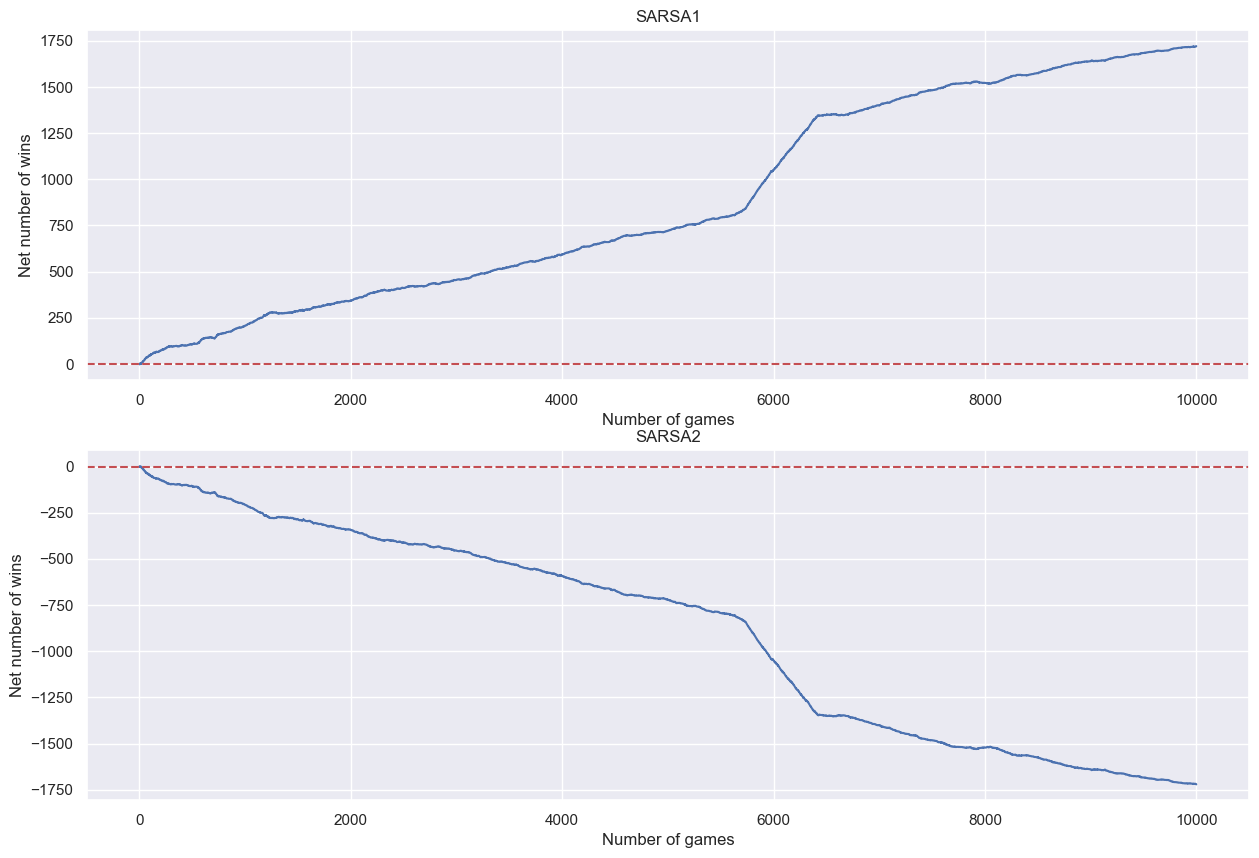

0.5686672499869019 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f9f4f7b5b80>,
 <__main__.SARSAPlayer at 0x7f9f4f7b5700>)

In [415]:
train_sarsa('board3', 10000, draw_reqs = False)

Training `SARSA1` and `SARSA2` for `10,000` games results in a draw proportion of about `67%`. Training time is less than a second.

#### Training for 100,000 games, draw_reqs = False

100%|████████████████████████████████| 100000/100000 [00:03<00:00, 28395.79it/s]


SARSA Player is trained
------------------------------
Number of games = 100000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2064 boards
W/D/L: 19331/70802/9867
Proportion of wins = 0.19331
Proportion of draws = 0.70802
Proportion of losses = 0.09867
------------------------------
SARSA2:
Have learnt 1758 boards
W/D/L: 9867/70802/19331
Proportion of wins = 0.09867
Proportion of draws = 0.70802
Proportion of losses = 0.19331


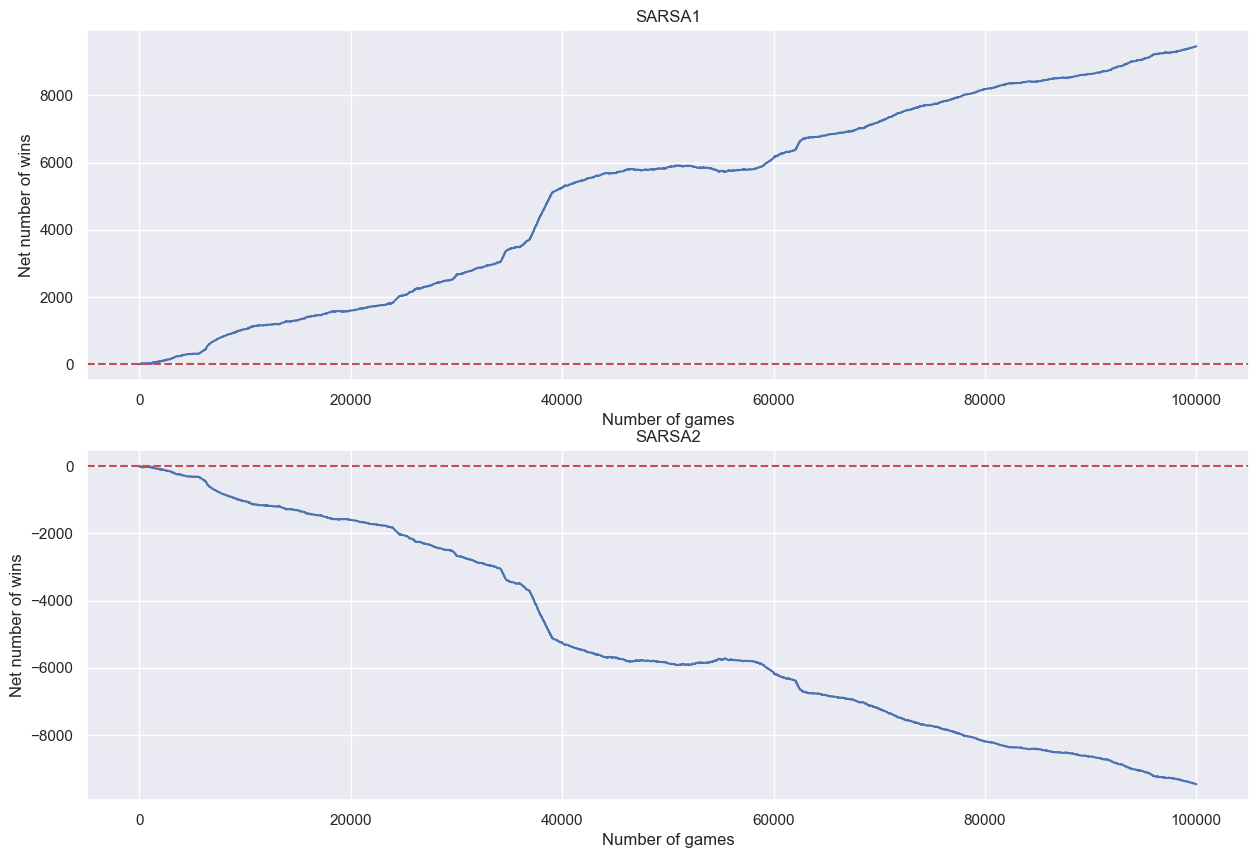

3.722425749991089 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f9f3f6b79a0>,
 <__main__.SARSAPlayer at 0x7f9f3f6b7130>)

In [420]:
train_sarsa('board3', 100000, draw_reqs = False)

Training for `100,000` games results in a draw proportion of about `70%` which is an improvement. Training time is about 4 seconds.

#### Training for 500,000 games, draw_reqs = False

100%|████████████████████████████████| 500000/500000 [00:18<00:00, 27580.01it/s]


SARSA Player is trained
------------------------------
Number of games = 500000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2345 boards
W/D/L: 89042/374417/36541
Proportion of wins = 0.178084
Proportion of draws = 0.748834
Proportion of losses = 0.073082
------------------------------
SARSA2:
Have learnt 2042 boards
W/D/L: 36541/374417/89042
Proportion of wins = 0.073082
Proportion of draws = 0.748834
Proportion of losses = 0.178084


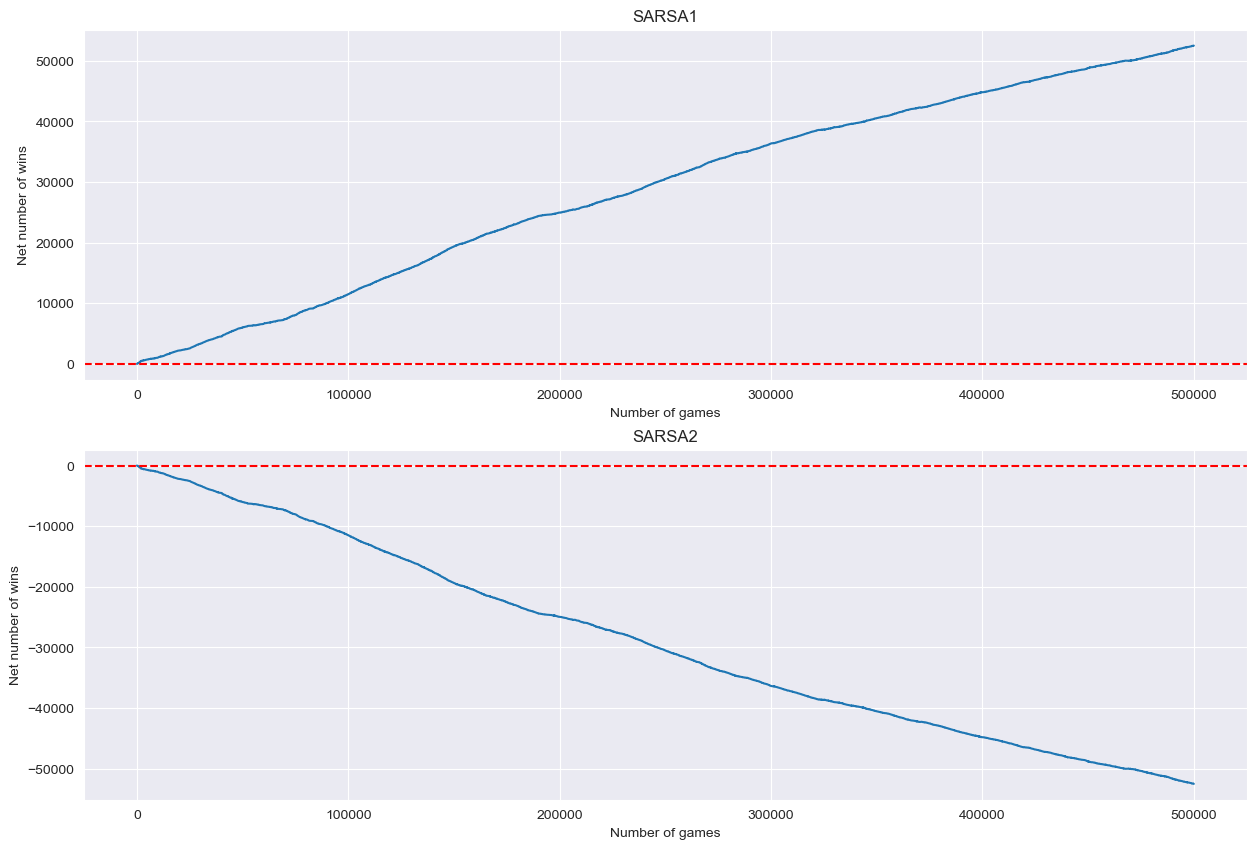

18.455832292000196 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f8d255fc1c0>,
 <__main__.SARSAPlayer at 0x7f8d255fc6a0>)

In [19]:
train_sarsa('board3', 500000, draw_reqs = False)

Training for `500,000` games results in a draw proportion of about `75%` which is once again a good improvement. Training time is about 19 seconds.

#### Training for 1,000,000 games, draw_reqs = False

100%|██████████████████████████████| 1000000/1000000 [00:35<00:00, 28268.93it/s]


SARSA Player is trained
------------------------------
Number of games = 1000000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2405 boards
W/D/L: 197702/719955/82343
Proportion of wins = 0.197702
Proportion of draws = 0.719955
Proportion of losses = 0.082343
------------------------------
SARSA2:
Have learnt 2085 boards
W/D/L: 82343/719955/197702
Proportion of wins = 0.082343
Proportion of draws = 0.719955
Proportion of losses = 0.197702


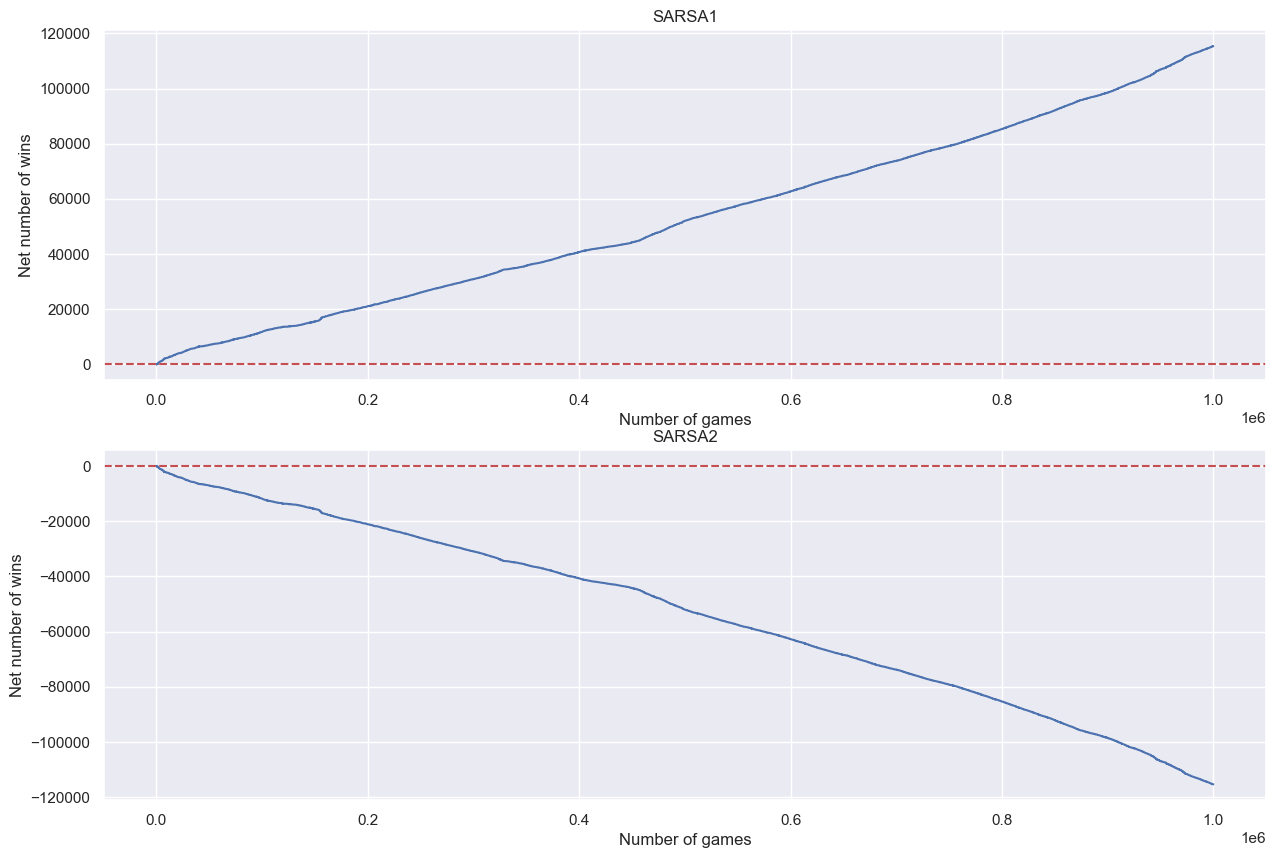

36.624325292010326 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f9e1c25ee50>,
 <__main__.SARSAPlayer at 0x7f9e1c25eb20>)

In [418]:
train_sarsa('board3', 1000000, draw_reqs = False)

Interestingly, if we train for `1,000,000` games, the draw proportion for the players decreases to about `72%`. Training time is roughly 37 seconds.

#### Training for 5,000,000 games, draw_reqs = False

100%|██████████████████████████████| 5000000/5000000 [02:53<00:00, 28739.58it/s]


SARSA Player is trained
------------------------------
Number of games = 5000000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2422 boards
W/D/L: 1134860/3283469/581671
Proportion of wins = 0.226972
Proportion of draws = 0.6566938
Proportion of losses = 0.1163342
------------------------------
SARSA2:
Have learnt 2096 boards
W/D/L: 581671/3283469/1134860
Proportion of wins = 0.1163342
Proportion of draws = 0.6566938
Proportion of losses = 0.226972


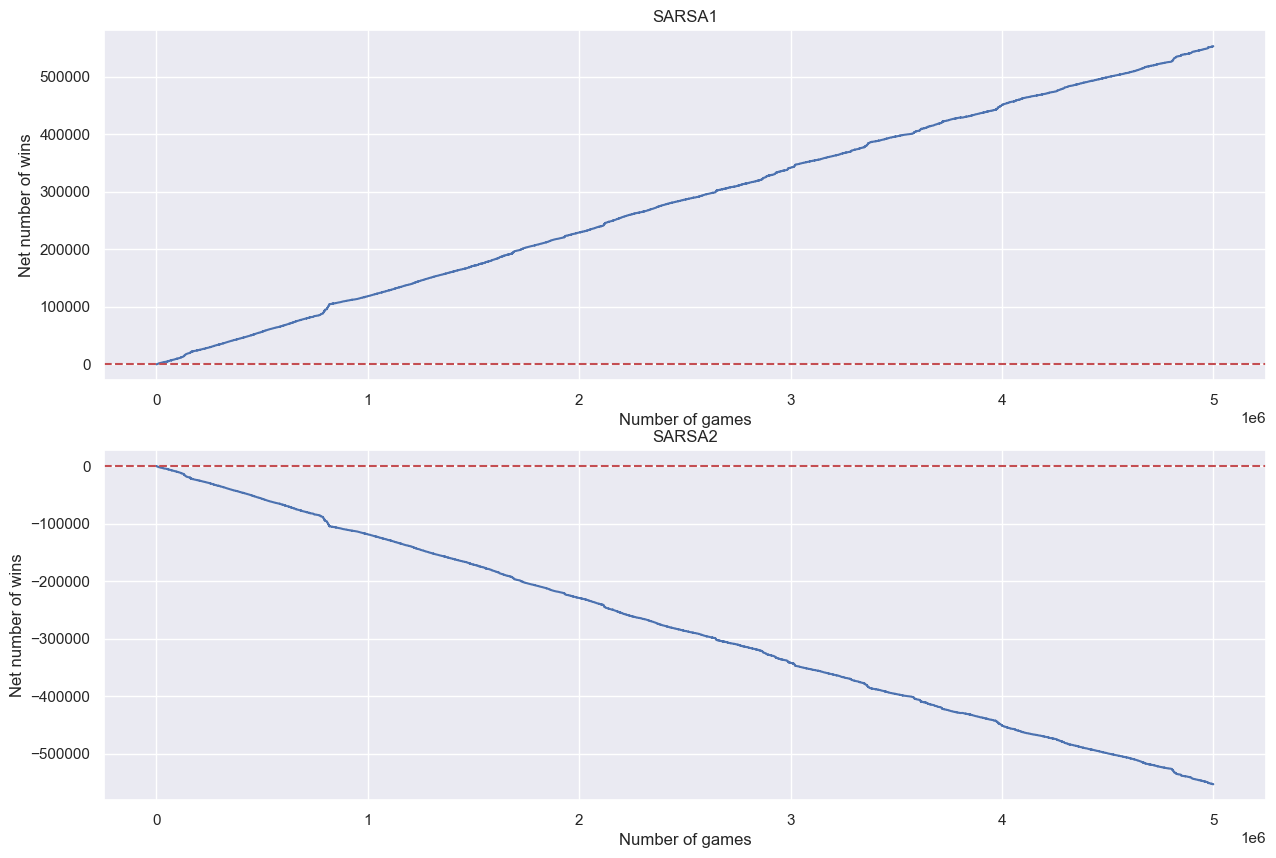

175.5403739999747 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f9e6fabf8b0>,
 <__main__.SARSAPlayer at 0x7f9f283d9100>)

In [421]:
train_sarsa('board3', 5000000, draw_reqs = False)

Now, if we train for `5,000,000` games, the draw rate decreases once again to about `65%`. This takes about 3 minutes.

#### Training for 10,000,000 games, draw_reqs = False

100%|████████████████████████████| 10000000/10000000 [05:43<00:00, 29150.34it/s]


SARSA Player is trained
------------------------------
Number of games = 10000000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2423 boards
W/D/L: 2360991/6363052/1275957
Proportion of wins = 0.2360991
Proportion of draws = 0.6363052
Proportion of losses = 0.1275957
------------------------------
SARSA2:
Have learnt 2095 boards
W/D/L: 1275957/6363052/2360991
Proportion of wins = 0.1275957
Proportion of draws = 0.6363052
Proportion of losses = 0.2360991


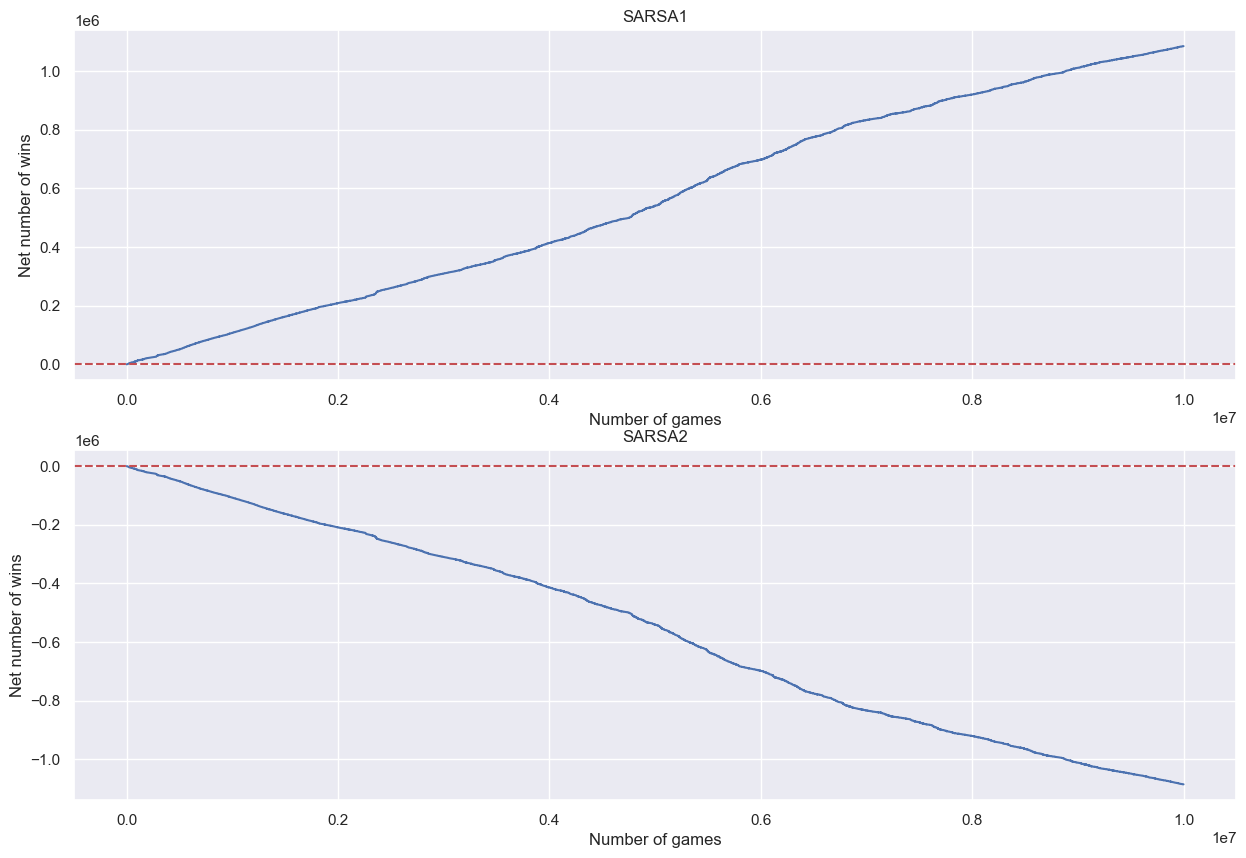

346.4452585830004 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f9e9d9bf610>,
 <__main__.SARSAPlayer at 0x7f9e9d9bf0a0>)

In [422]:
train_sarsa('board3', 10000000, draw_reqs = False)

Training the players for `10,000,000` games further decreased the draw rate to about `64%`. This suggests that after a certain point, increasing the number of games no longer improves the percentage of draws for both `SARSAPlayer`.

Training for `10,000,000` games took about 6 minutes.

Carrying forwards, we will train the players for `500,000` games as this resulted in the largest draw proportion (without enforcing draw requirements).

#### Training for 500,000 games, draw_reqs = True

100%|████████████████████████████████| 500000/500000 [00:18<00:00, 27507.75it/s]


SARSA Player is trained
------------------------------
Number of games = 500000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2394 boards
W/D/L: 81604/372009/46387
Proportion of wins = 0.163208
Proportion of draws = 0.744018
Proportion of losses = 0.092774
------------------------------
SARSA2:
Have learnt 2061 boards
W/D/L: 46387/372009/81604
Proportion of wins = 0.092774
Proportion of draws = 0.744018
Proportion of losses = 0.163208


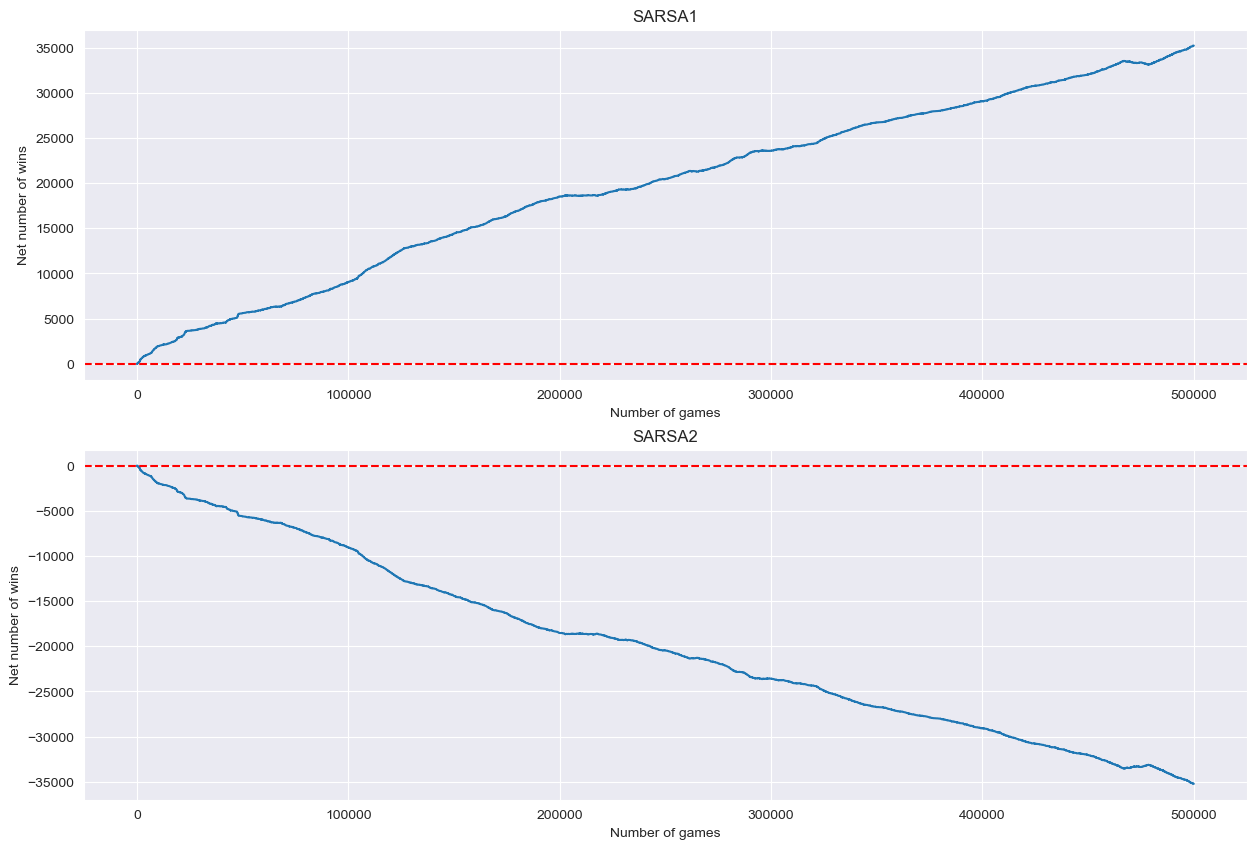

18.50514291699983 seconds elapsed.


In [24]:
board3_s1, board3_s2 = train_sarsa('board3', 500000, draw_reqs = True, draw_threshold = 0.7)

This time, we force the draw requirements and threshold to be met. Training for `500,000` games with `draw_reqs = True` results in a draw rate of about `74%`, similar to before when we didn't enforce the draw requirement. 

This takes about 19 seconds.

#### Training for 500,000 games, draw_reqs = True, draw_threshold = 0.75

100%|████████████████████████████████| 500000/500000 [00:18<00:00, 27507.66it/s]


SARSA Player is trained
------------------------------
Number of games = 500000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 2353 boards
W/D/L: 82877/376803/40320
Proportion of wins = 0.165754
Proportion of draws = 0.753606
Proportion of losses = 0.08064
------------------------------
SARSA2:
Have learnt 2032 boards
W/D/L: 40320/376803/82877
Proportion of wins = 0.08064
Proportion of draws = 0.753606
Proportion of losses = 0.165754


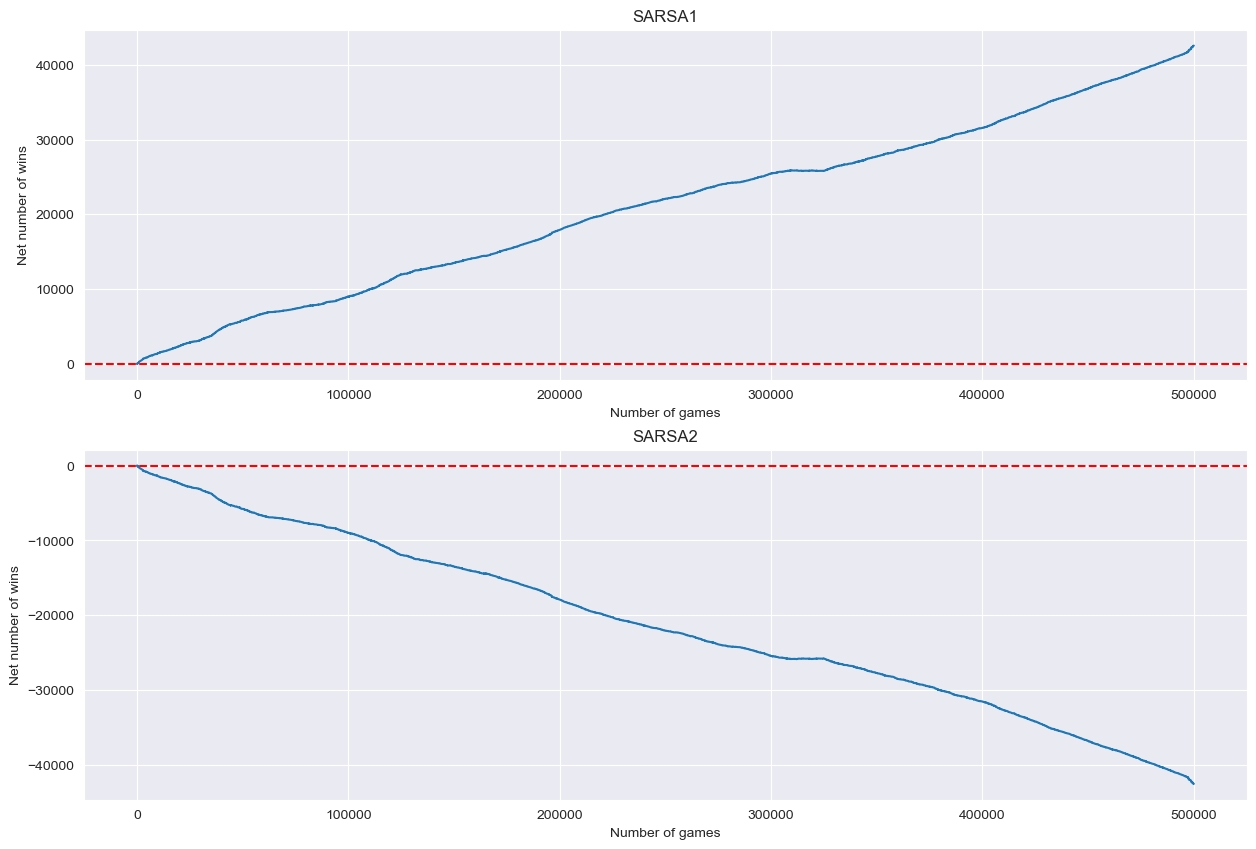

18.445480624999618 seconds elapsed.


In [36]:
board3_s1, board3_s2 = train_sarsa('board3', 500000, draw_reqs = True, draw_threshold = 0.75)

If we train for `500,000` games and enforce `draw_threshold = 0.75`, this results in a draw proportion of just above `75%`. This took about 19 seconds, which is the same as before.

For the same number of games, we also tried training the players while enforcing `draw_threshold = 0.8`, however, this caused the the function to reach the maximum number of trials (`100`), hence breaking the loop and stopping the training (these codes were excluded). This took roughly 1 hour.

We also tried training for `1,000,000` games with  `draw_threshold = 0.75`, and it required the function to train 19 times, taking roughly 12 minutes (these codes were excluded). This was much more computationally expensive considering the small level of improvement. This further proved that increasing the number of games too much does not benefit the training process.

Therefore, we decided to stop the training of the two `SARSAPlayer` objects here and thus, we end up with two players, `board3_s1` and `board3_s2`, both with draw proportions `75%`. We can tell straightaway that these players are much less optimal compared to the trained `MENACEPlayer` objects from before, which reached a draw rate of `99.5%` (almost perfectly optimal). 

We can play a game against the trained `SARSAPlayer`:

##### board3_s1 vs human

In [39]:
play_game('board3', board3_s1, HumanPlayer())

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  
Make a move: 4

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  

 0 | 1 | 2     X |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | O |  
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  
Make a move: 3

 0 | 1 | 2     X |   |  
---+---+---   ---+---+---
 3 | 4 | 5     O | O |  
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  

 0 | 1 | 2     X | X |  
---+---+---   ---+---+---
 3 | 4 | 5     O | O |  
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  
Make a move: 5

 0 | 1 | 2     X | X |  
---+---+---   ---+---+---
 3 | 4 | 5     O | O | O
---+---+---   ---+---+---
 6 | 7 | 8     X |   |  
You won!


On move 3 (`board3_s1`'s 2nd move), `board3_s1` learned to block our potential three in a row at position `3`.

On move 5 (`board3_s1`'s 3rd move), `board3_s1` did not block our potential three in a row at position `5`.
This lead to our victory when playing position `5`.

As `board3_s1`'s draw rates are about `75%`, it is expected that `board3_s1` still cannot optimally force a draw.

#### *human vs board3_s2*

In [41]:
play_game('board3', HumanPlayer(), board3_s2)

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 4

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   | O
Make a move: 5

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X | X
---+---+---   ---+---+---
 6 | 7 | 8       |   | O

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X | X
---+---+---   ---+---+---
 6 | 7 | 8     O |   | O
Make a move: 3

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5     X | X | X
---+---+---   ---+---+---
 6 | 7 | 8     O |   | O
You won!


On move 4 (`board3_s2`'s 2nd move), `board3_s2` did not block our potential three in a row at position `3`. This lead to our victory when playing position `3`.

Interestingly, for both `board3_s1` and `board3_s2`, they were more interested in forming their own three in a rows than blocking their opponent's moves. This suggests that the algorithm values a potential win more than a forced draw.

### 4x4 board

#### Training for 100,000 games, draw_reqs = False

100%|█████████████████████████████████| 100000/100000 [00:10<00:00, 9471.20it/s]


SARSA Player is trained
------------------------------
Number of games = 100000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 32839 boards
W/D/L: 4290/92172/3538
Proportion of wins = 0.0429
Proportion of draws = 0.92172
Proportion of losses = 0.03538
------------------------------
SARSA2:
Have learnt 34103 boards
W/D/L: 3538/92172/4290
Proportion of wins = 0.03538
Proportion of draws = 0.92172
Proportion of losses = 0.0429


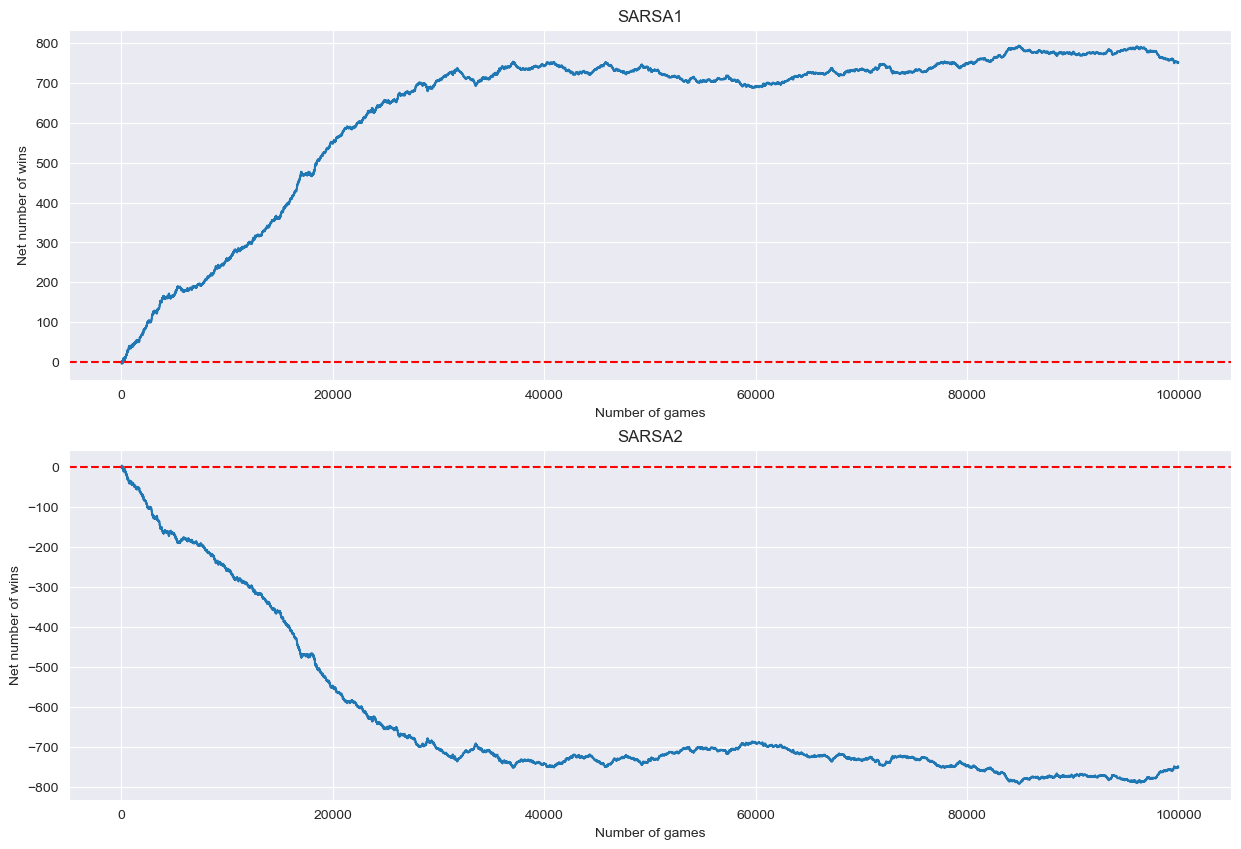

10.810725291999915 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f8d278e5970>,
 <__main__.SARSAPlayer at 0x7f8d278e5eb0>)

In [57]:
train_sarsa('board4', 100000, draw_reqs = False)

Training for `100,000` games resulted in about a `92%` draw rate. This is immediately an improvement from training the `3x3` board for `100,000` games which resulted in a draw rate of `70%`.

This took about 10 seconds.

#### Training for 1,000,000 games, draw_reqs = False

100%|██████████████████████████████| 1000000/1000000 [01:32<00:00, 10862.63it/s]


SARSA Player is trained
------------------------------
Number of games = 1000000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 93025 boards
W/D/L: 17622/961730/20648
Proportion of wins = 0.017622
Proportion of draws = 0.96173
Proportion of losses = 0.020648
------------------------------
SARSA2:
Have learnt 95732 boards
W/D/L: 20648/961730/17622
Proportion of wins = 0.020648
Proportion of draws = 0.96173
Proportion of losses = 0.017622


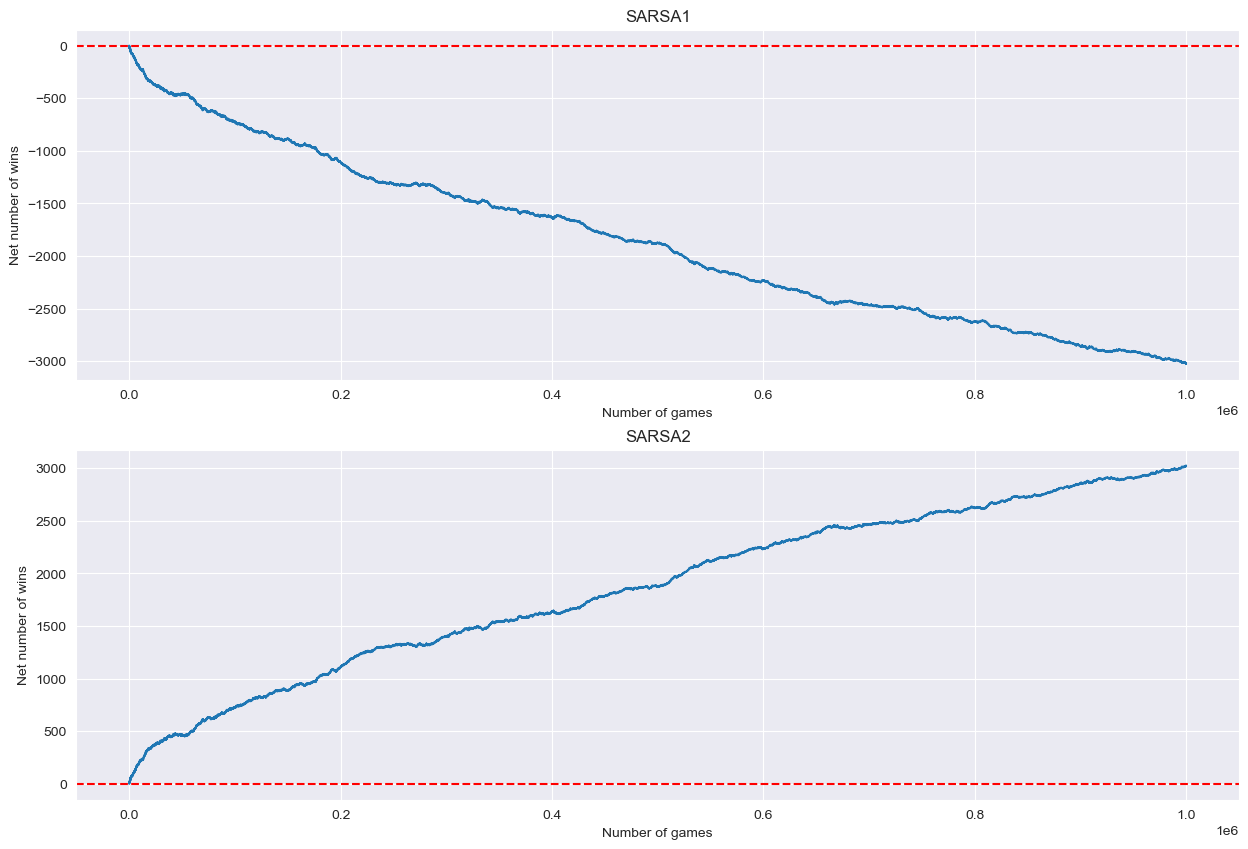

92.54835408299914 seconds elapsed.


(<__main__.SARSAPlayer at 0x7f8d579cc820>,
 <__main__.SARSAPlayer at 0x7f8d25622d60>)

In [59]:
train_sarsa('board4', 1000000, draw_reqs = False)

Training for `1,000,000` games resulted in a draw rate of `96%`, which is a really good improvement. This took about 1.5 minutes. 

When training the `3x3` board for `1,000,000`, a draw rate of `72%` was reached. 

Additionally, for the `4x4` board, training `MENACEPlayer` for `1,000,000` games resulted in a draw rate of only `44%`. This suggests that, overall, the combination of the `SARSAPlayer` with a `4x4` board performs better.

#### Training for 10,000,000 games, draw_reqs = False

100%|████████████████████████████| 10000000/10000000 [15:02<00:00, 11078.98it/s]


SARSA Player is trained
------------------------------
Number of games = 10000000
Number of trials = 1
------------------------------
SARSA1:
Have learnt 209011 boards
W/D/L: 91497/9831894/76609
Proportion of wins = 0.0091497
Proportion of draws = 0.9831894
Proportion of losses = 0.0076609
------------------------------
SARSA2:
Have learnt 207404 boards
W/D/L: 76609/9831894/91497
Proportion of wins = 0.0076609
Proportion of draws = 0.9831894
Proportion of losses = 0.0091497


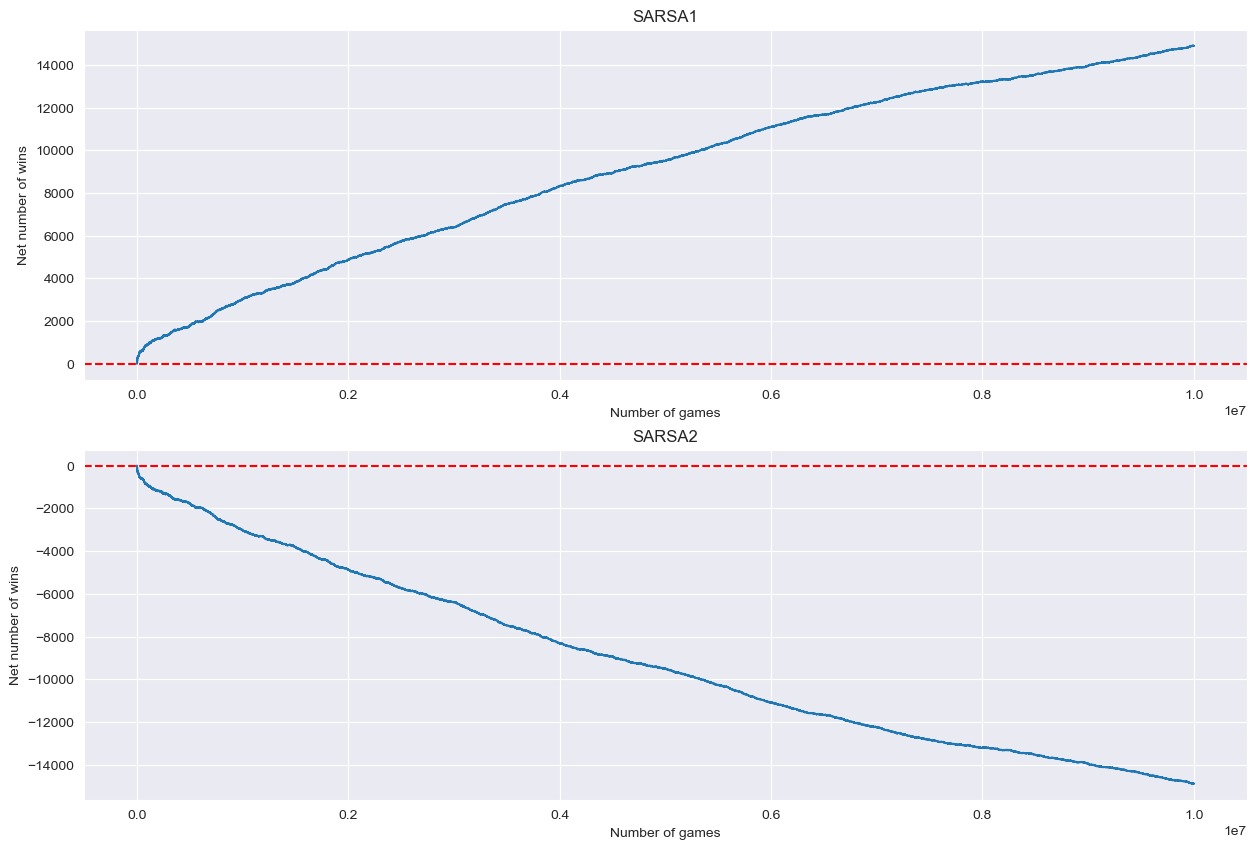

905.3255552079991 seconds elapsed.


In [66]:
board4_s1, board4_s2 = train_sarsa('board4', 10000000, draw_reqs = False)

Training for `10,000,000` games further increased the draw proportion to `98%`, which is nearly optimal. 

This took about 15 minutes. 

We also tried enforcing draw requirements with `draw_threshold = 0.99`, however, we interrupted the process when the computational time exceeded 2 hours (these codes were excluded). Hence, we stopped training here and end up with two players, `board4_s1` and `board4_s2`, both with draw rate of `98%`. 

We conclude that, the *SARSA* algorithm performs much better for the `4x4` board than the `3x3` board.

##### board4_s1 vs human

In [62]:
play_game('board4', board4_s1, HumanPlayer())

Get ready!


Starting a new game!

  0 |  1 |  2 |  3        |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   

  0 |  1 |  2 |  3        |  X |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 15

  0 |  1 |  2 |  3        |  X |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |  O

  0 |  1 |  2 |  3      X |  X |    |   
----+----+----+----   ----+----+---

`board4_s1` has learned to force a draw.

##### human vs board4_s2

In [93]:
play_game('board4', HumanPlayer(), board4_s2)

Get ready!


Starting a new game!

  0 |  1 |  2 |  3        |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 0

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   

  0 |  1 |  2 |  3      X |    |    |  O
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 5

  0 |  1 |  2 |  3      X |    |    |  O
----+----+----+----  

Strangely, `board4_s2` made no attempts in blocking us at all, giving us the victory. This goes against its `98%` draw rate as it appears that it was making random moves and being untrained. Further discussion will be made below.

## Q-Learning

A slight variation of the *SARSA* algorithm explored in the previous section is *Q-Learning*<sup>4</sup>, which is a widely-used model-free reinforcement learning algorithm used to learn the value of an action in a particular state. As the *“Q”* in *Q-Learning* stands for quality, this algorithm assesses the quality of taking a certain action in a given state. 

Unlike *SARSA*, which is an on-policy algorithm, *Q-Learning* is an off-policy algorithm. While *SARSA* chooses an action by following the current policy that is being used, the *Q-Learning* algorithm chooses the greedy action. This follows an optimal policy, which gives the maximum *Q*-value for the state. Hence, the process of updating the estimated state-action value function is also slighty different. We can break down the calculation of $Q(\textbf{s},\textbf{a})$ as follows. 

First, we write the Bellman optimality equation for the optimal value function as:

$$ V^{{\pi}^{opt}}(\textbf{s})=\max_{\textbf{a}}\mathbb{E}[r+\gamma V^{{\pi}^{opt}}(\textbf{s'})]$$

Transferring the above formula, we write the Bellman optimality equation for the optimal *Q*-Function:

$$ Q^{{\pi}^{opt}}(\textbf{s},\textbf{a})=\mathbb{E}[r+\gamma\max_{\textbf{a'}}Q^{{\pi}^{opt}}(\textbf{s'},\textbf{a'})]$$

By using the formulas above, we obtain the one-step *Q-Learning* update rule:

$$Q(\textbf{s},\textbf{a})\leftarrow Q(\textbf{s},\textbf{a})+\alpha[r+\gamma\max_{\textbf{a}} Q(\textbf{s'},\textbf{a})-Q(\textbf{s},\textbf{a})]$$

Where:
-	$r$ is the immediate reward
-	$\alpha$ is the learning rate. This determines the impact of newly aquired information on older information.
-	$\gamma$ is the discount factor. This determines the importance of future rewards.
-	$\textbf{a’}$ is the next action
-	$\textbf{s’}$ is the next state

The *Q*-function is updated iteratively until it converges to the *optimal* *Q*-function. 

### QLearningPlayer

Similarly to `SARSAPlayer`, we create an extended subclass to the original `MenacePlayer` called `QLearningPlayer` that uses the Q-Learning algorithm to learn from its experience during the games. This class also overrides `MenacePlayer`'s definitions of `get_move`, `win_game`, `draw_game`, and `lose_game` by introducing new methods for Q-Learning.

The attributes and functions in `QLearningPlayer` are the same as `SARSAPlayer` unless stated otherwise.
- `self.q_values` is a dictionary that stores the state-action values for the learned policy.
- `get_move(self, board)` selects a move based on the learned policy using the epsilon-greedy algorithm.
- `update_q_values(self, reward)` updates the state-action values using the Q-Learning algorithm.
- `win_game(self)`, `draw_game(self)`, and `lose_game(self)` are similar to those of `SARSAPlayer`, but call the above `update_q_values` function instead.

The main difference between `SARSAPlayer` and `QLearningPlayer` is that,
- `SARSAPlayer` updates the state-action values based on the state-action value for the next state and the actual action taken in the next state. This is an on-policy reinforcement learning algorithm.
- `QLearningPlayer` updates the state-action values based on the maximum state-action value for the next state and action, regardless of the action taken in the next state. This is an off-policy reinforcement learning algorithm.

In [42]:
import random
from collections import defaultdict

class QLearningPlayer(MenacePlayer):
    def __init__(self, alpha = 0.1, gamma = 0.9, epsilon = 0.1):
        super().__init__()
        self.q_values = defaultdict(lambda: defaultdict(float))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.unique_boards = set()

    def get_move(self, board):
        board_str = board.board_string()
        valid_moves = [pos for pos, mark in enumerate(board_str) if mark == ' ']

        if random.random() < self.epsilon:
            move = random.choice(valid_moves)
        else:
            move = max(valid_moves, key=lambda x: self.q_values[board_str][x])

        self.moves_played.append((board_str, move))
        self.unique_boards.add(board_str)
        return move

    def update_q_values(self, reward):
        for i in reversed(range(len(self.moves_played) - 1)):
            board, move = self.moves_played[i]
            next_board, next_move = self.moves_played[i + 1]
            self.q_values[board][move] += self.alpha * (reward + self.gamma * np.max(self.q_values[next_board][next_move]) - self.q_values[board][move])
            reward = 0

    def win_game(self):
        self.update_q_values(1)
        self.num_win += 1
        self.net_win += 1
        self.history.append(self.net_win)

    def draw_game(self):
        self.update_q_values(0.5)
        self.num_draw += 1
        self.net_win += 0
        self.history.append(self.net_win)

    def lose_game(self):
        self.update_q_values(-1)
        self.num_lose += 1
        self.net_win -= 1
        self.history.append(self.net_win)
        
    def print_stats(self):
        print('Have learnt %d boards' % len(self.unique_boards))
        print('W/D/L: %d/%d/%d' % (self.num_win, self.num_draw, self.num_lose))
        
    def print_probability(self, board):
        pass

### Function to train Q-Learning player 1 and player 2

Similarly to training the `MENACEPlayer` and the `SARSAPlayer`, we now create a function `train_q` to run multiple games between two players who use the *Q-Learning* algorithm, and train them.

While the architecture and the outputs of this training fuction is the same as that of `train_menace` and `train_sarsa`, here, `train_q` starts by initialising `q1` and `q2` as initial `QLearningPlayer` each. Once again, we make use of the arguments `draw_reqs` and `draw_threshold` as we want the `QLearningPlayer` objects to be trained optimally.

Once trained, the function prints the statistics and plots the net number of wins over each game for both `QLearningPlayer`.

In [43]:
def train_q(game, games, draw_reqs = True, draw_threshold = 0.7, max_trials = 100):
    start = timer()
    trained = False
    num_trials = 0
    
    while not trained:
        q1 = QLearningPlayer()
        q2 = QLearningPlayer()
        
        for _ in tqdm(range(games)):
            play_game(game, q1, q2, silent = True)
            
        num_trials += 1
        
        if draw_reqs == True:
            if (q1.num_draw > q1.num_win > q1.num_lose) & ((q1.num_draw / games) >= draw_threshold):
                trained = True
            else:
                trained = False
                
                if num_trials == max_trials:
                    print('Unable to train the Q-Learning player with the draw requirements.')
                    print('Try again with more games or a higher max_trials or a lower draw_threshold.')
                    end = timer()
                    print('{} seconds elapsed.'.format(end - start))
                    break
        
        else:
            trained = True
        
    if trained == True:
        print('Q-Learning Player is trained')
        print('------------------------------')
        print('Number of games = {}'.format(games))
        print('Number of trials = {}'.format(num_trials))
        print('------------------------------')
        print('q1:')
        q1.print_stats()
        print('Proportion of wins = {}'.format(q1.num_win / games))
        print('Proportion of draws = {}'.format(q1.num_draw / games))
        print('Proportion of losses = {}'.format(q1.num_lose / games))
        print('------------------------------')
        print('q2:')
        q2.print_stats()
        print('Proportion of wins = {}'.format(q2.num_win / games))
        print('Proportion of draws = {}'.format(q2.num_draw / games))
        print('Proportion of losses = {}'.format(q2.num_lose / games))
        
        fig, ax = plt.subplots(2, figsize = (15, 10))
        ax[0].plot(q1.history)
        ax[0].axhline(y = 0, color = 'r', linestyle = '--')
        ax[0].set_title('q1')
        ax[0].set_xlabel('Number of games')
        ax[0].set_ylabel('Net number of wins')
        ax[1].plot(q2.history)
        ax[1].axhline(y = 0, color = 'r', linestyle = '--')
        ax[1].set_title('q2')
        ax[1].set_xlabel('Number of games')
        ax[1].set_ylabel('Net number of wins');
        plt.show()
        
        end = timer()
        print('{} seconds elapsed.'.format(end - start))
        
        return q1, q2

## Training Q-Learning Players

### 3x3 board

We directly start with `100,000` games.

#### Training for 100,000 games, draw_reqs = False

100%|████████████████████████████████| 100000/100000 [00:06<00:00, 15210.82it/s]


Q-Learning Player is trained
------------------------------
Number of games = 100000
Number of trials = 1
------------------------------
q1:
Have learnt 1979 boards
W/D/L: 22137/71707/6156
Proportion of wins = 0.22137
Proportion of draws = 0.71707
Proportion of losses = 0.06156
------------------------------
q2:
Have learnt 1731 boards
W/D/L: 6156/71707/22137
Proportion of wins = 0.06156
Proportion of draws = 0.71707
Proportion of losses = 0.22137


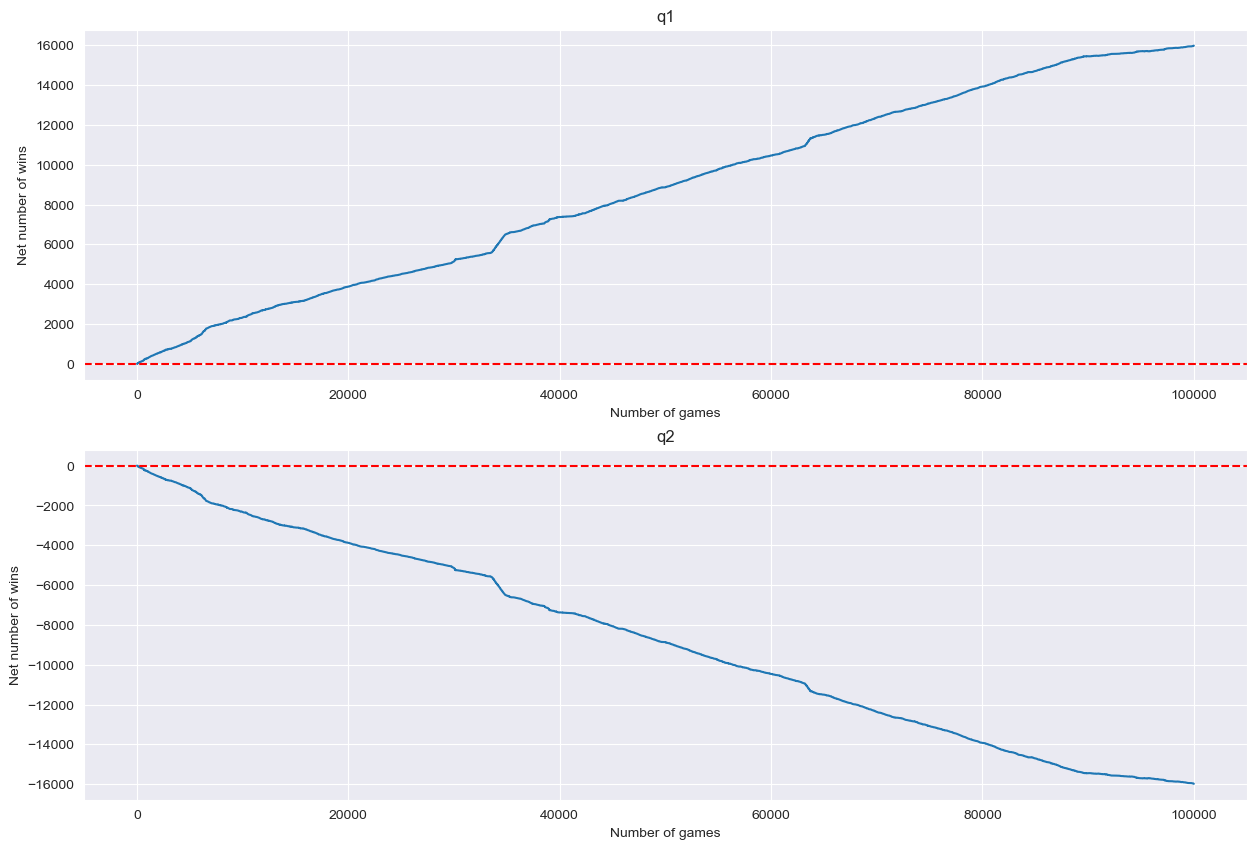

6.80001112500031 seconds elapsed.


(<__main__.QLearningPlayer at 0x7f8db655bdc0>,
 <__main__.QLearningPlayer at 0x7f8db655b0a0>)

In [45]:
train_q('board3', 100000, draw_reqs = False)

Training for `100,000` games resulted in a draw proportion of about `72%`. Training time is about 7 seconds.

#### Training for 500,000 games, draw_reqs = False

100%|████████████████████████████████| 500000/500000 [00:32<00:00, 15347.76it/s]


Q-Learning Player is trained
------------------------------
Number of games = 500000
Number of trials = 1
------------------------------
q1:
Have learnt 2337 boards
W/D/L: 90012/365297/44691
Proportion of wins = 0.180024
Proportion of draws = 0.730594
Proportion of losses = 0.089382
------------------------------
q2:
Have learnt 2026 boards
W/D/L: 44691/365297/90012
Proportion of wins = 0.089382
Proportion of draws = 0.730594
Proportion of losses = 0.180024


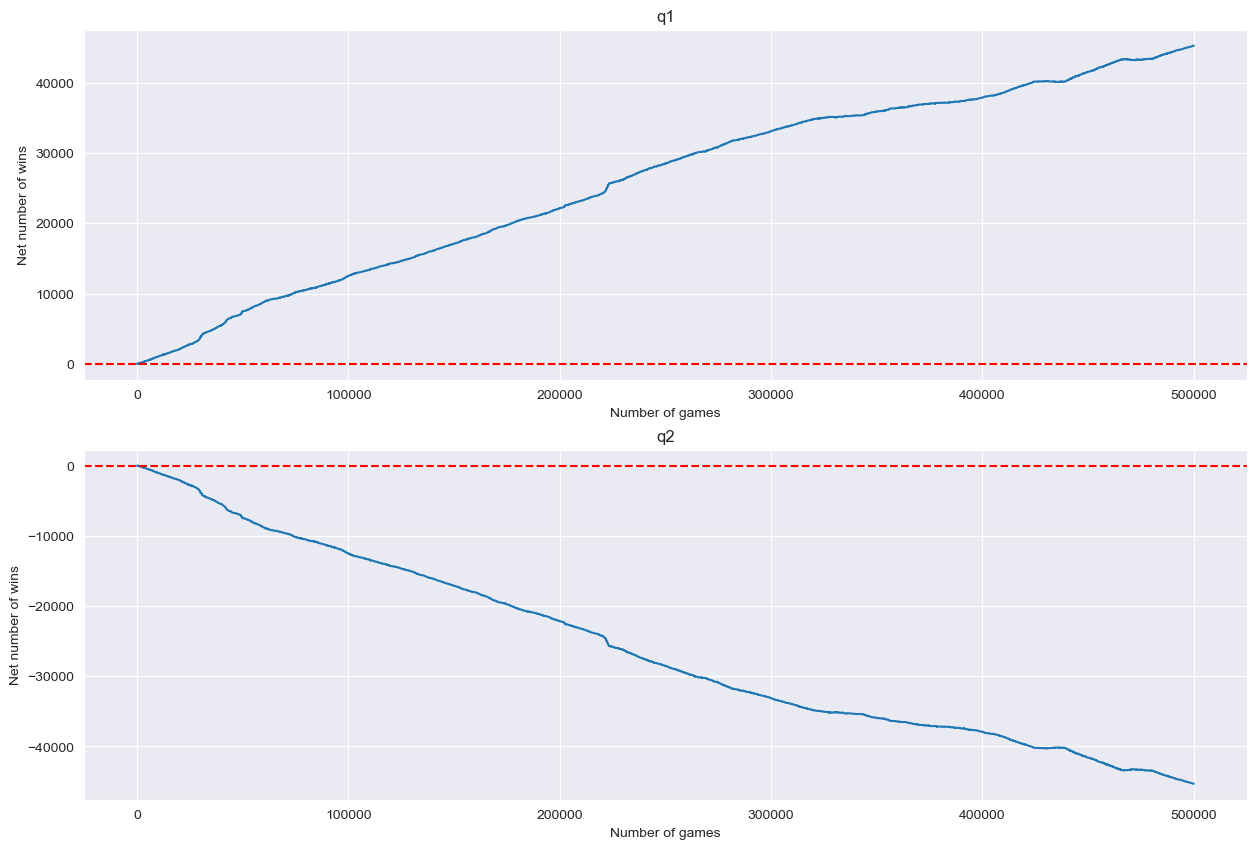

32.908329500000036 seconds elapsed.


(<__main__.QLearningPlayer at 0x7f8d42b50af0>,
 <__main__.QLearningPlayer at 0x7f8d536292e0>)

In [47]:
train_q('board3', 500000, draw_reqs = False)

Training for `500,000` games resulted in a draw proportion of about `73%` which is an improvement. This took roughly 33 seconds.

#### Training for 1,000,000 games, draw_reqs = False

100%|██████████████████████████████| 1000000/1000000 [01:04<00:00, 15556.41it/s]


Q-Learning Player is trained
------------------------------
Number of games = 1000000
Number of trials = 1
------------------------------
q1:
Have learnt 2391 boards
W/D/L: 210936/695477/93587
Proportion of wins = 0.210936
Proportion of draws = 0.695477
Proportion of losses = 0.093587
------------------------------
q2:
Have learnt 2076 boards
W/D/L: 93587/695477/210936
Proportion of wins = 0.093587
Proportion of draws = 0.695477
Proportion of losses = 0.210936


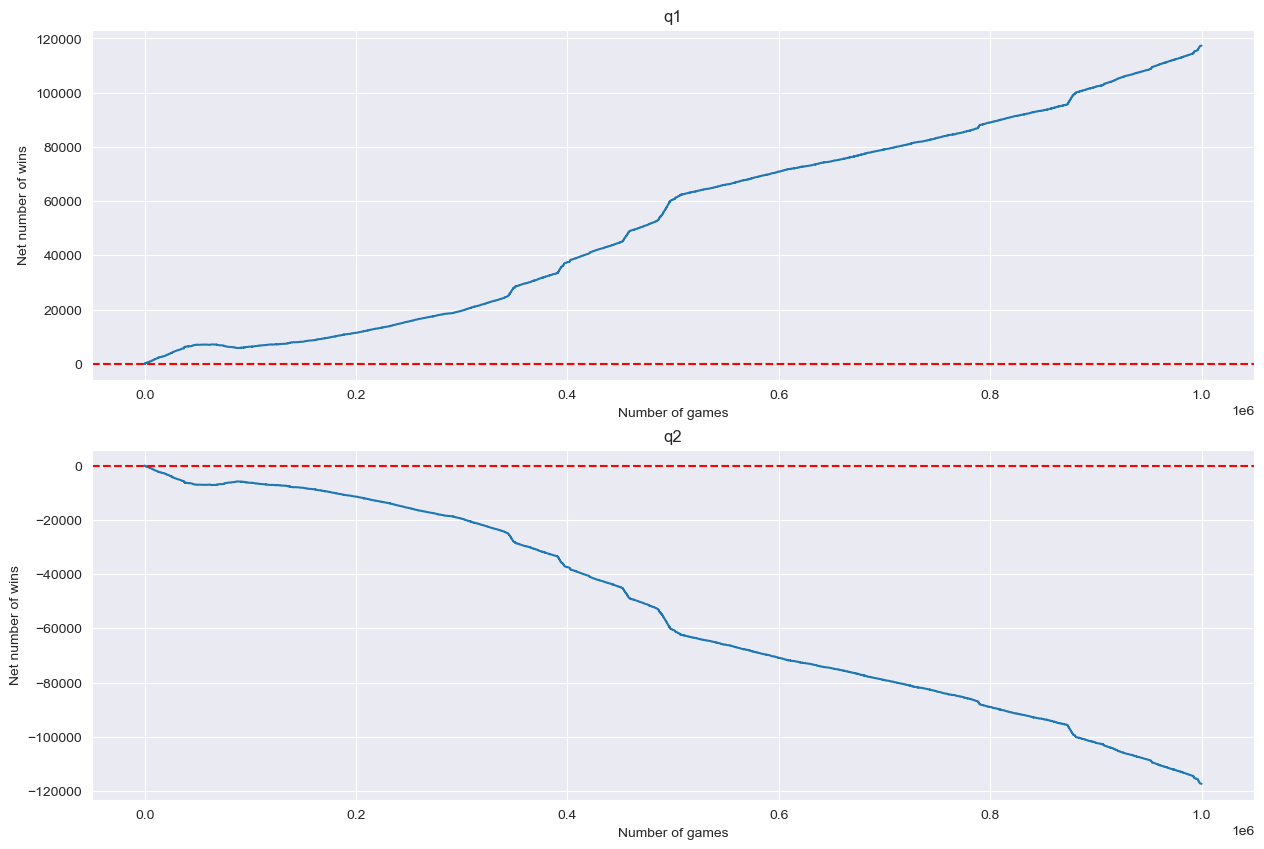

64.75381058399944 seconds elapsed.


(<__main__.QLearningPlayer at 0x7f8d949ee910>,
 <__main__.QLearningPlayer at 0x7f8d949ee370>)

In [48]:
train_q('board3', 1000000, draw_reqs = False)

Training for `1,000,000` games decreased the draw proportion to almost `70%` compared to training for `500,000` games. This took about a minute.

#### Training for 7,000,000 games, draw_reqs = False

100%|██████████████████████████████| 7000000/7000000 [07:22<00:00, 15818.59it/s]


Q-Learning Player is trained
------------------------------
Number of games = 7000000
Number of trials = 1
------------------------------
q1:
Have learnt 2420 boards
W/D/L: 1569282/4538239/892479
Proportion of wins = 0.22418314285714286
Proportion of draws = 0.6483198571428571
Proportion of losses = 0.127497
------------------------------
q2:
Have learnt 2097 boards
W/D/L: 892479/4538239/1569282
Proportion of wins = 0.127497
Proportion of draws = 0.6483198571428571
Proportion of losses = 0.22418314285714286


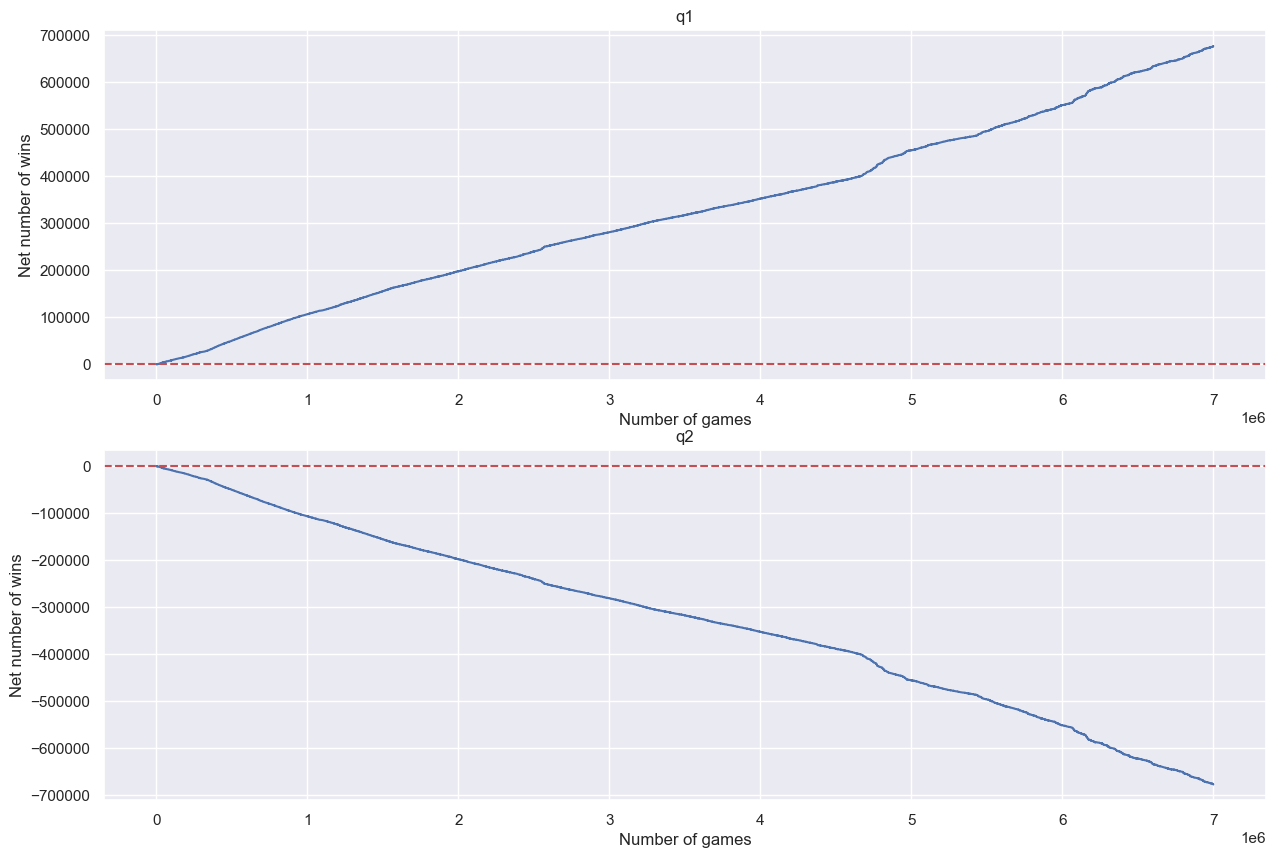

444.72236029198393 seconds elapsed.


(<__main__.QLearningPlayer at 0x7f9ec39e0e20>,
 <__main__.QLearningPlayer at 0x7f9ec39e05e0>)

In [424]:
train_q('board3', 7000000, draw_reqs = False)

Training for `7,000,000` games further decreased the draw proportion to about `65%`. Following a similar pattern to training the `SARSAPlayer` objects, this suggests that after a certain number of games, the draw proportion no longer improves. 

This took about 7.5 minutes.

Carrying forwards, we will train for `500,000` as this resulted in the largest draw proportion.


#### Training for 500,000 games, draw_reqs = True

As previously seen, training for `500,000` games resulted in meeting the original draw threshold (`0.7`) without enforcing the draw requirements. Hence, we now enforce `draw_reqs = True`, and increase `draw_threshold` to `0.75`.

100%|████████████████████████████████| 500000/500000 [00:34<00:00, 14455.13it/s]


Q-Learning Player is trained
------------------------------
Number of games = 500000
Number of trials = 5
------------------------------
q1:
Have learnt 2384 boards
W/D/L: 81758/375331/42911
Proportion of wins = 0.163516
Proportion of draws = 0.750662
Proportion of losses = 0.085822
------------------------------
q2:
Have learnt 2067 boards
W/D/L: 42911/375331/81758
Proportion of wins = 0.085822
Proportion of draws = 0.750662
Proportion of losses = 0.163516


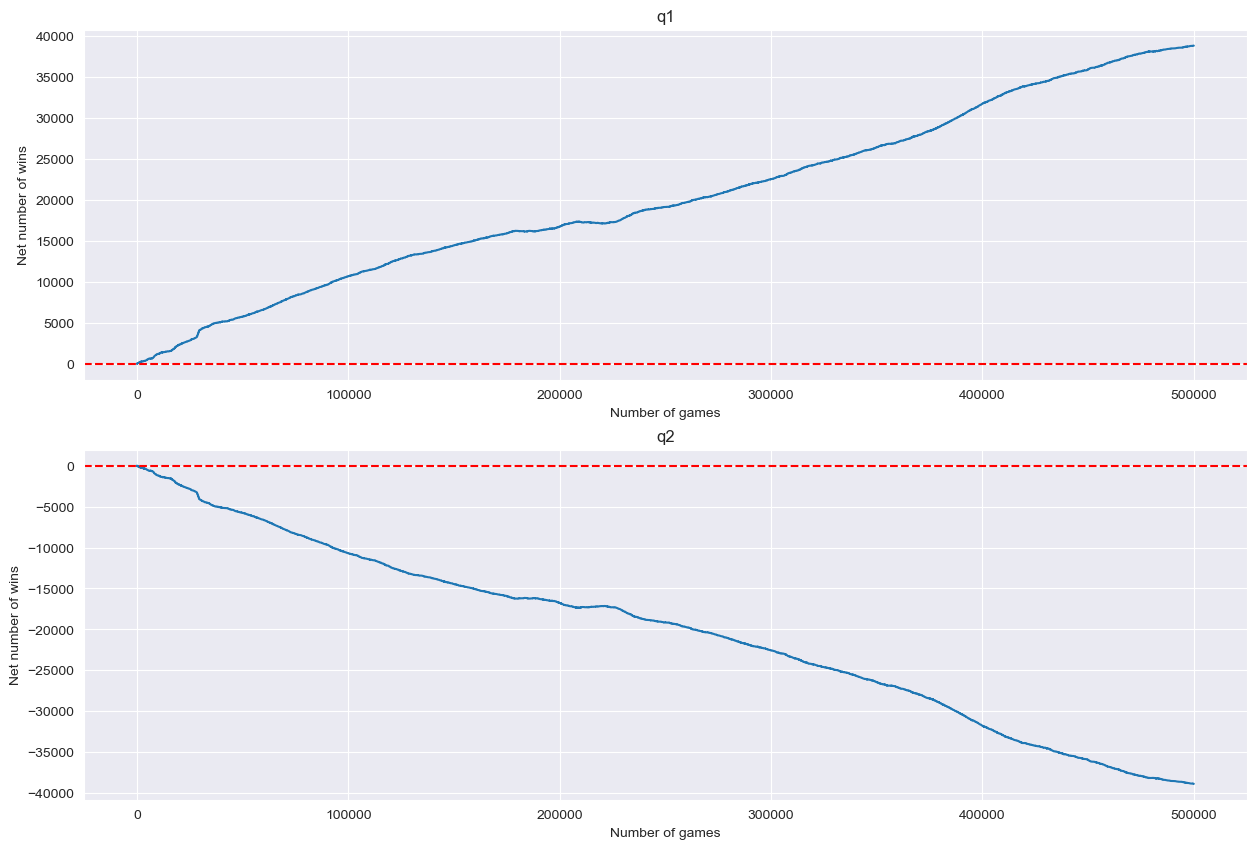

165.59027074999995 seconds elapsed.


In [49]:
board3_q1, board3_q2 = train_q('board3', 500000, draw_reqs = True, draw_threshold = 0.75)

Previously, when training for `500,000` games, a draw proportion of `73%` was reached. This took about 33 seconds. Once we enforced `draw_threshold = 0.75` for the same amount of games, the function had to train 5 times, taking roughly 3 minutes. 

We also increased `draw_threshold` to `0.8`, but after it reached 50 trials, we interrupted the training (these codes were excluded). Due to the drastic increase of computational time, we decided not to train the players any further (with higher `draw_threshold`). Hence, we end up with two players, `board3_q1` and `board3_q2`, both with draw proportions of about `75%`.

We can play a game against the trained `QLearningPlayer`:

##### board3_q1 vs human

In [51]:
play_game('board3', board3_q1, HumanPlayer())

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 5

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X | O
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       |   | X
---+---+---   ---+---+---
 3 | 4 | 5       | X | O
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 6

 0 | 1 | 2       |   | X
---+---+---   ---+---+---
 3 | 4 | 5       | X | O
---+---+---   ---+---+---
 6 | 7 | 8     O |   |  

 0 | 1 | 2       |   | X
---+---+---   ---+---+---
 3 | 4 | 5     X | X | O
---+---+---   ---+---+---
 6 | 7 | 8     O |   |  
Make a move: 7

 0 | 1 | 2       |   | X
---+---+---   ---+---+---
 3 | 4 | 5     X | X | O
---+---+---   ---+---+---
 6 | 7 | 8     O | O |  

 0 | 1 | 2     X |   | X

On move 5 (`board3_q1`'s 3rd move), `board3_q1` strangely chose to play at position `3`, which does not help in creating any potential three in a rows.

On move 7 (`board3_q1`s 4th move), `board3_q1` did not block our potential three in a row at position `8`. This lead to our victory when playing position `8`.

As `board3_q1`'s draw rates are about `75%`, it is expected that `board3_s1` still cannot optimally force a draw.

##### human vs board3_q2

In [53]:
play_game('board3', HumanPlayer(), board3_q2)

Get ready!


Starting a new game!

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       |   |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 4

 0 | 1 | 2       |   |  
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       |   | O
---+---+---   ---+---+---
 3 | 4 | 5       | X |  
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 5

 0 | 1 | 2       |   | O
---+---+---   ---+---+---
 3 | 4 | 5       | X | X
---+---+---   ---+---+---
 6 | 7 | 8       |   |  

 0 | 1 | 2       | O | O
---+---+---   ---+---+---
 3 | 4 | 5       | X | X
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
Make a move: 3

 0 | 1 | 2       | O | O
---+---+---   ---+---+---
 3 | 4 | 5     X | X | X
---+---+---   ---+---+---
 6 | 7 | 8       |   |  
You won!


On move 4 (`board3_q2`'s 2nd move), `board3_q2` did not block our potential three in a row at position `3`. This lead to our victory when playing position `3`.

Similarly to `board3_s1` and `board3_s2`, `board3_q2` was more interested in forming their own three in a rows than blocking their opponent's moves. This either suggests that the algorithm values a potential win more than a forced draw, or that they are still not optimal enough to draw a conclusion.

### 4x4 board

We directly start with `1,000,000` games (following the pattern for training `SARSAPlayer` for the `4x4` board, we expect the draw rate to increase with inceasing number of games).

#### Training for 1,000,000 games, draw_reqs = False

100%|███████████████████████████████| 1000000/1000000 [02:33<00:00, 6503.52it/s]


Q-Learning Player is trained
------------------------------
Number of games = 1000000
Number of trials = 1
------------------------------
q1:
Have learnt 94356 boards
W/D/L: 17230/968932/13838
Proportion of wins = 0.01723
Proportion of draws = 0.968932
Proportion of losses = 0.013838
------------------------------
q2:
Have learnt 96048 boards
W/D/L: 13838/968932/17230
Proportion of wins = 0.013838
Proportion of draws = 0.968932
Proportion of losses = 0.01723


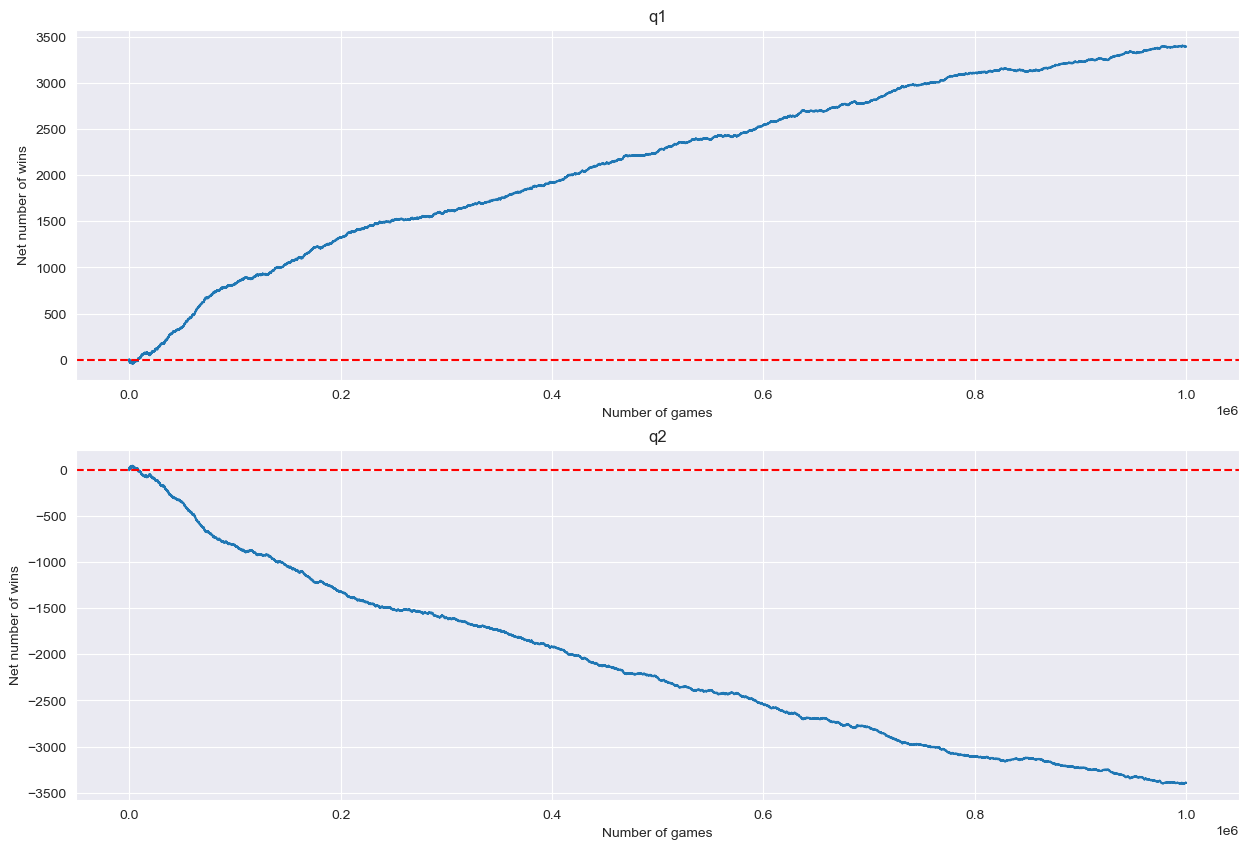

154.2608489590002 seconds elapsed.


(<__main__.QLearningPlayer at 0x7f8d43779ee0>,
 <__main__.QLearningPlayer at 0x7f8d43779700>)

In [73]:
train_q('board4', 1000000, draw_reqs = False)

Training for `1,000,000` games resulted in a draw rate of about `97%`. This took about 2.5 minutes. 

When training for `1,000,000` games using *SARSA*, a draw rate of `96%` was reached, which is quite similar.

Training for `1,000,000` games for the `3x3` board (using *Q-Learning*) resulted in a draw rate of about `70%`, hence playing with a `4x4` board results in very significant improvement.

#### Training for 10,000,000 games, draw_reqs = False

100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [47:33<00:00, 3505.03it/s]


Q-Learning Player is trained
------------------------------
Number of games = 10000000
Number of trials = 1
------------------------------
q1:
Have learnt 249709 boards
W/D/L: 86997/9816284/96719
Proportion of wins = 0.0086997
Proportion of draws = 0.9816284
Proportion of losses = 0.0096719
------------------------------
q2:
Have learnt 251039 boards
W/D/L: 96719/9816284/86997
Proportion of wins = 0.0096719
Proportion of draws = 0.9816284
Proportion of losses = 0.0086997


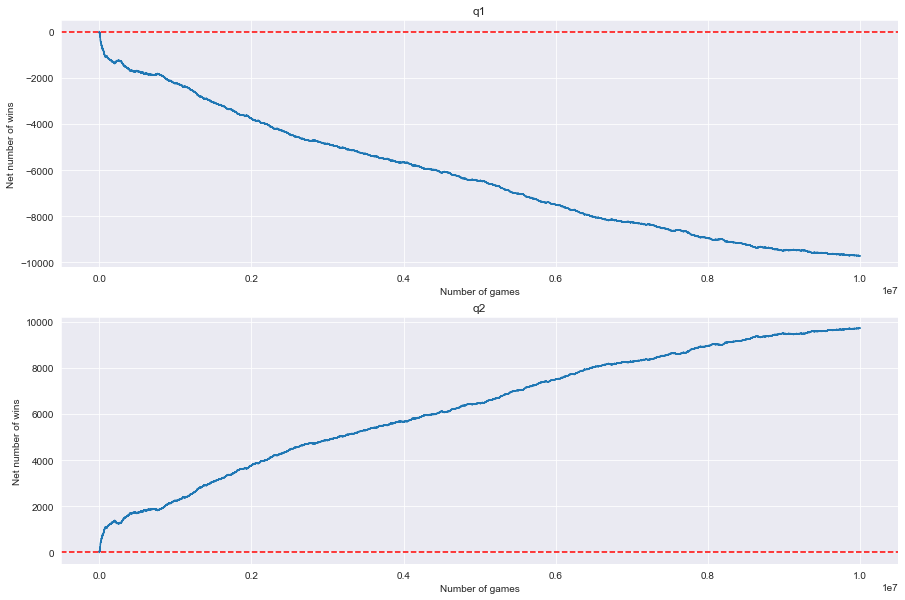

2860.9743039000023 seconds elapsed.


In [73]:
board4_q1, board4_q2 = train_q('board4', 10000000, draw_reqs = False)

Training for `10,000,000` games further increased the draw proportion to about `98%`, which is nearly optimal. This took about 26 minutes. 

When training for `1,000,000` games using *SARSA*, a draw rate of about `98%` was reached, which is the same.

Due to the time complexity, we stopped training here and thus, end up with two players, `board4_q1` and `board4_q2`, both with draw rate of `98%`. 

We conclude that, the *Q-Learning* algorithm performs much better for the `4x4` board than the `3x3` board. Moreover, for `4x4` board, *SARSA* and *Q-Learning* have very similar performance.

##### board4_q1 vs human

In [92]:
play_game('board4', board4_q1, HumanPlayer())

Get ready!


Starting a new game!

  0 |  1 |  2 |  3        |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   

  0 |  1 |  2 |  3        |  X |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 15

  0 |  1 |  2 |  3        |  X |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |  O

  0 |  1 |  2 |  3        |  X |    |   
----+----+----+----   ----+----+---

`board4_q1` has learned to force a draw.

##### human vs board4_q2

In [75]:
play_game('board4', HumanPlayer(), board4_q2)

Get ready!


Starting a new game!

  0 |  1 |  2 |  3        |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   
Make a move: 0

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15        |    |    |   

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----   ----+----+----+----
  4 |  5 |  6 |  7        |    |    |   
----+----+----+----   ----+----+----+----
  8 |  9 | 10 | 11        |    |    |   
----+----+----+----   ----+----+----+----
 12 | 13 | 14 | 15      O |    |    |   
Make a move: 5

  0 |  1 |  2 |  3      X |    |    |   
----+----+----+----  

Strangely, just like `board4_s2`, `board4_q2` made no attempts in blocking us at all, giving us the victory. This goes against its `98%` draw rate as it appears that it was making random moves and being untrained. Further discussion will be made below.

## Comparing MENACE, SARSA, and Q-Learning

### Plotting average Q-values over games played (SARSA vs Q-Learning)

#### 3x3 board

We create two empty lists `average_q_values_sarsa` and `average_q_values_q`. We initialise two players for the *SARSA* algorithm and play `1,000,000` games. This is repeated for the *Q-Learning* algorithm. After every 1000 games, the average q-value is calculated and appended to each respective list. 

In [322]:
s1 = SARSAPlayer()
s2 = SARSAPlayer()
average_q_values_sarsa = []
for i in tqdm(range(1000000)):
    play_game('board3', s1, s2, silent=True)
    if i % 1000 == 0:
        q_values = []
        for board, move in s1.q_values_sarsa.items():
            for action, value in move.items():
                q_values.append(value)
        average_q_values_sarsa.append(sum(q_values) / len(q_values))

q1 = QLearningPlayer()
q2 = QLearningPlayer()        
average_q_values_q = []
for i in tqdm(range(1000000)):
    play_game('board3', q1, q2, silent=True)
    if i % 1000 == 0:
        q_values = []
        for board, move in q1.q_values.items():
            for action, value in move.items():
                q_values.append(value)
        average_q_values_q.append(sum(q_values) / len(q_values))

100%|██████████████████████████████| 1000000/1000000 [01:03<00:00, 15654.51it/s]


Finally, we plot `average_q_values_sarsa` and `average_q_values_q`. This shows us the progression of the average q-values over time, giving us insights about the learning process of each algorithm.

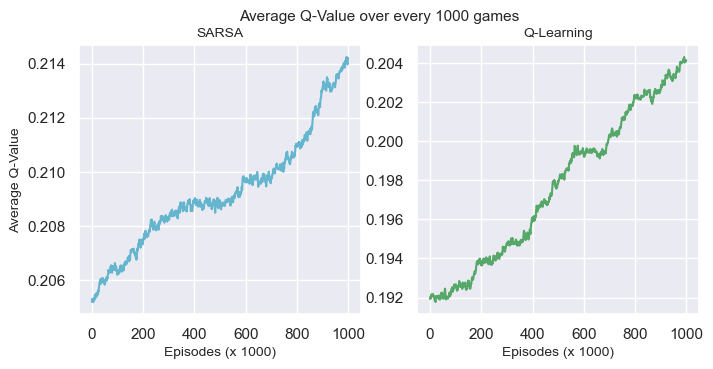

In [323]:
_, ax = plt.subplots(1,2, figsize=(8, 3.5))
ax[0].plot(range(len(average_q_values_sarsa)), average_q_values_sarsa, label='SARSA', color = 'c')
ax[1].plot(range(len(average_q_values_q)), average_q_values_q, label='Q-learning', color = 'g')
ax[0].set_xlabel('Episodes (x 1000)', fontsize = 10)
ax[0].set_ylabel('Average Q-Value', fontsize = 10)
ax[0].set_title('SARSA', fontsize = 10)
ax[1].set_xlabel('Episodes (x 1000)', fontsize = 10)
ax[1].set_title('Q-Learning', fontsize = 10)
_.suptitle('Average Q-Value over every 1000 games', fontsize=11)
plt.show()

These results indicate that the q-values have not converged yet, as there is still an upward trend. This means that the learning process has not yet stabilised. This may be caused by insufficient exploration.

Since the average q-values for the *SARSA* algorithm are slightly higher, this suggests that it is more effective at learning the optimal policy for the game. This backs up the results we got earlier after training the players for `1,000,000` games (without draw requirements). `board3_s1` and `board3_s2` had draw rate of `72.0%`, while `board3_q1` and `board3_q2` had draw rate of `69.55%`. 

#### 4x4 board

We repeat the above steps for Board 4.

In [114]:
s1 = SARSAPlayer()
s2 = SARSAPlayer()
average_q_values_sarsa = []
for i in tqdm(range(1000000)):
    play_game('board4', s1, s2, silent=True)
    if i % 1000 == 0:
        q_values = []
        for board, move in s1.q_values_sarsa.items():
            for action, value in move.items():
                q_values.append(value)
        average_q_values_sarsa.append(sum(q_values) / len(q_values))

q1 = QLearningPlayer()
q2 = QLearningPlayer()        
average_q_values_q = []
for i in tqdm(range(1000000)):
    play_game('board4', q1, q2, silent=True)
    if i % 1000 == 0:
        q_values = []
        for board, move in q1.q_values.items():
            for action, value in move.items():
                q_values.append(value)
        average_q_values_q.append(sum(q_values) / len(q_values))

100%|███████████████████████████████| 1000000/1000000 [04:02<00:00, 4122.24it/s]


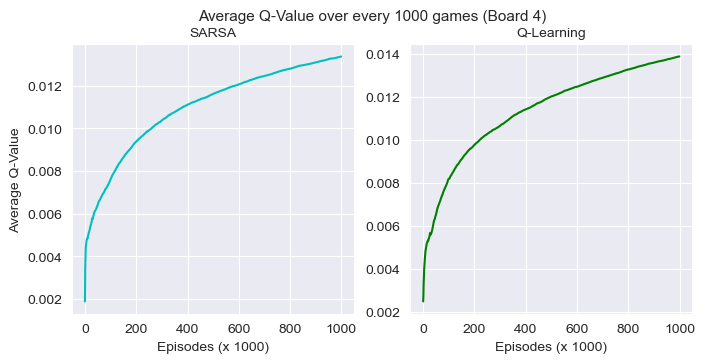

In [120]:
_, ax = plt.subplots(1,2, figsize=(8, 3.5))
ax[0].plot(range(len(average_q_values_sarsa)), average_q_values_sarsa, label='SARSA', color = 'c')
ax[1].plot(range(len(average_q_values_q)), average_q_values_q, label='Q-learning', color = 'g')
ax[0].set_xlabel('Episodes (x 1000)', fontsize = 10)
ax[0].set_ylabel('Average Q-Value', fontsize = 10)
ax[0].set_title('SARSA', fontsize = 10)
ax[1].set_xlabel('Episodes (x 1000)', fontsize = 10)
ax[1].set_title('Q-Learning', fontsize = 10)
_.suptitle('Average Q-Value over every 1000 games (Board 4)', fontsize=11)
plt.show()

Here, we can see that the average q-values have converged, suggesting that the learning process has in fact stabilised. Overall, the *Q-Learning* algorithm results in higher average q-values, suggesting that, for the`4x4` board, it is more effective at learning the optimal policy. However, since the difference is very little, we cannot undermine the performance of *SARSA* either. 

Previously, when we trained the players for the `4x4` board, `board4_s1` and `board4_s2` reached draw rate of about `98%`. `board4_q1` and `board4_q2` also reached draw rate of about `98%`. This suggests that the performance of both these algorithms are very similar.

### Plotting number of Wins/Draws/Losses for the players of MENACE, SARSA, and Q-Learning

#### 3x3 board

First, we initialise players for each method.

In [109]:
m1 = MenacePlayer()
m2 = MenacePlayer()

s1 = SARSAPlayer()
s2 = SARSAPlayer()

q1 = QLearningPlayer()
q2 = QLearningPlayer()

For a general comparison, we train the pairs of players (for each method) for the same number of games, without enforcing draw requirements. 

Here, we use the command `%%capture` to silence the output of the cell since we do not require the details of the training.

In [110]:
%%capture

m1, m2 = train_menace('board3', 1000000, draw_reqs = False)
    
s1, s2 = train_sarsa('board3', 1000000, draw_reqs = False)

q1, q2 = train_q('board3', 1000000, draw_reqs = False)

We create data frames containg the statistics for these players.

In [112]:
data_menace_board3 = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Number of games': [m1.num_win, m1.num_draw, m1.num_lose, m2.num_win, m2.num_draw, m2.num_lose]}
data_sarsa_board3 = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Number of games': [s1.num_win, s1.num_draw, s1.num_lose, s2.num_win, s2.num_draw, s2.num_lose]}
data_q_board3 = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Number of games': [q1.num_win, q1.num_draw, q1.num_lose, q2.num_win, q2.num_draw, q2.num_lose]}

df_menace_board3 = pd.DataFrame(data_menace_board3)
df_sarsa_board3 = pd.DataFrame(data_sarsa_board3)
df_q_board3 = pd.DataFrame(data_q_board3)

We can now plot the bar charts. For better interpretability, we add the number of wins/draws/losses over each bar.

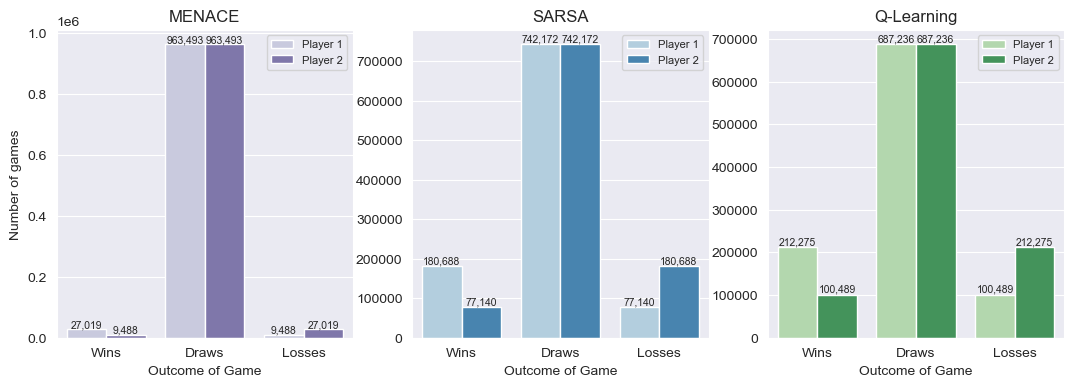

In [113]:
_, ax = plt.subplots(1,3, figsize=(13, 4))
sns.barplot(x='Outcome', y='Number of games', hue='Player', data=df_menace_board3, palette='Purples', ax = ax[0])
sns.barplot(x='Outcome', y='Number of games', hue='Player', data=df_sarsa_board3, palette='Blues', ax = ax[1])
sns.barplot(x='Outcome', y='Number of games', hue='Player', data=df_q_board3, palette='Greens', ax = ax[2])


ax[0].set_title('MENACE')
ax[1].set_title('SARSA')
ax[2].set_title('Q-Learning')
ax[0].set_ylabel('Number of games', fontsize = 10)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[0].set_xlabel('Outcome of Game', fontsize = 10)
ax[1].set_xlabel('Outcome of Game', fontsize = 10)
ax[2].set_xlabel('Outcome of Game', fontsize = 10)
ax[0].legend(title=None, fontsize = 8)
ax[1].legend(title=None, fontsize = 8)
ax[2].legend(title=None, fontsize = 8)


for u, v in enumerate(ax[0].patches):
    value = v.get_height() + 6000
    x_cord_centre = v.get_x() + v.get_width() / 2
    ax[0].text(x_cord_centre, value, f"{df_menace_board3['Number of games'][u]:,}", size=7.5, ha='center')
    
for u, v in enumerate(ax[1].patches):
    value = v.get_height() + 6000
    x_cord_centre = v.get_x() + v.get_width() / 2
    ax[1].text(x_cord_centre, value, f"{df_sarsa_board3['Number of games'][u]:,}", size=7.5, ha='center')
    
for u, v in enumerate(ax[2].patches):
    value = v.get_height() + 6000
    x_cord_centre = v.get_x() + v.get_width() / 2
    ax[2].text(x_cord_centre, value, f"{df_q_board3['Number of games'][u]:,}", size=7.5, ha='center')

    
plt.show()

As explored and discussed about earlier, in terms the performance, and the effectiveness of learning the optimal policy for the `3x3` board, we can rank the three methods in order of best to worst:
1. MENACE
2. SARSA
3. Q-Learning

Now, we will employ bar charts to visualise the statistics of the trained pairs of players, `board3_menace1` and `board3_menace2`, `board3_s1` and `board3_s2`, and `board3_q1` and `board3_q2`. In this case, since the number of games played while training are different, we plot the proportions instead of the true values. 

Using the results, we can compare the level of optimality of the algorithms. 

We begin by creating data frames containg the statistics for the trained players.

In [84]:
games_menace = 10000000
games_sarsa = 500000
games_q = 500000

data_menace_board3_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [board3_menace1.num_win/games_menace, board3_menace1.num_draw/games_menace, 
                            board3_menace1.num_lose/games_menace, board3_menace2.num_win/games_menace,
                            board3_menace2.num_draw/games_menace, board3_menace2.num_lose/games_menace]}
data_sarsa_board3_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [board3_s1.num_win/games_sarsa, board3_s1.num_draw/games_sarsa, 
                            board3_s1.num_lose/games_sarsa, board3_s2.num_win/games_sarsa,
                            board3_s2.num_draw/games_sarsa, board3_s2.num_lose/games_sarsa]}
data_q_board3_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [board3_q1.num_win/games_q, board3_q1.num_draw/games_q, 
                            board3_q1.num_lose/games_q, board3_q2.num_win/games_q,
                            board3_q2.num_draw/games_q, board3_q2.num_lose/games_q]}

df_menace_board3_trained = pd.DataFrame(data_menace_board3_trained)
df_sarsa_board3_trained = pd.DataFrame(data_sarsa_board3_trained)
df_q_board3_trained = pd.DataFrame(data_q_board3_trained)

We can now plot the bar charts. 

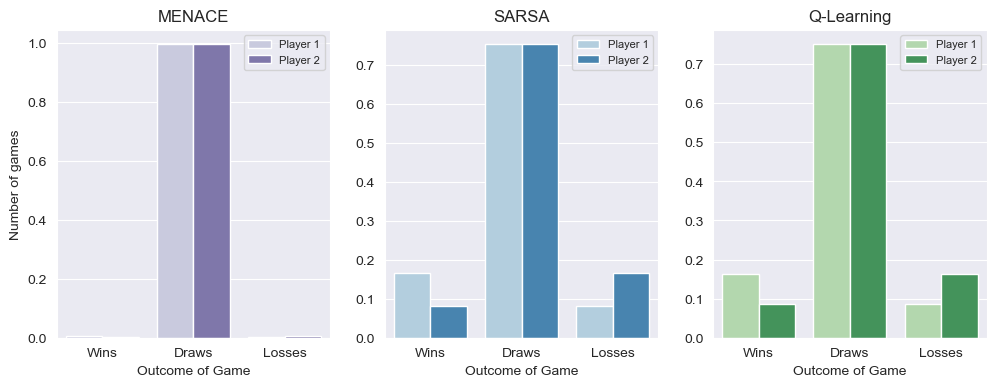

In [118]:
_, ax = plt.subplots(1,3, figsize=(12, 4))
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_menace_board3_trained, palette='Purples', ax = ax[0])
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_sarsa_board3_trained, palette='Blues', ax = ax[1])
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_q_board3_trained, palette='Greens', ax = ax[2])


ax[0].set_title('MENACE')
ax[1].set_title('SARSA')
ax[2].set_title('Q-Learning')
ax[0].set_ylabel('Number of games', fontsize = 10)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[0].set_xlabel('Outcome of Game', fontsize = 10)
ax[1].set_xlabel('Outcome of Game', fontsize = 10)
ax[2].set_xlabel('Outcome of Game', fontsize = 10)
ax[0].legend(title=None, fontsize = 8)
ax[1].legend(title=None, fontsize = 8)
ax[2].legend(title=None, fontsize = 8)

    
plt.show()

Further proving our earlier observation, the `MenacePlayer` objects perform the best for the `3x3` board. These players are almost perfectly optimal, with draw proportion of nearly `100%`. In contrast, the `SARSAPlayer` and `QLearningPlayer` objects are must less optimal, both having draw proportions of about `75%`.

#### 4x4 board

We will visualise the statistics of the trained pairs of players, `board4_menace1` and `board4_menace2`, `board4_s1` and `board4_s2`, and `board4_q1` and `board4_q2`. In this case, since the number of games played while training are different, we plot the proportions instead of the true values. 

Since the training of `board4_menace1` and `board4_menace2` took almost 24 hours, we decided not to train this again, and manually added the statistics.

We repeat the steps as above.

In [115]:
games_menace = 50000000
games_sarsa = 10000000
games_q = 10000000

data_menace_board4_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [10063797/games_menace, 31764601/games_menace, 
                            8171602/games_menace, 8171602/games_menace,
                            31764601/games_menace, 10063797/games_menace]}
data_sarsa_board4_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [board4_s1.num_win/games_sarsa, board4_s1.num_draw/games_sarsa, 
                            board4_s1.num_lose/games_sarsa, board4_s2.num_win/games_sarsa,
                            board4_s2.num_draw/games_sarsa, board4_s2.num_lose/games_sarsa]}
data_q_board4_trained = {'Player': ['Player 1', 'Player 1', 'Player 1', 'Player 2', 'Player 2', 'Player 2'],
        'Outcome': ['Wins', 'Draws', 'Losses', 'Wins', 'Draws', 'Losses'],
        'Proportion of games': [board4_q1.num_win/games_q, board4_q1.num_draw/games_q, 
                            board4_q1.num_lose/games_q, board4_q2.num_win/games_q,
                            board4_q2.num_draw/games_q, board4_q2.num_lose/games_q]}

df_menace_board4_trained = pd.DataFrame(data_menace_board4_trained)
df_sarsa_board4_trained = pd.DataFrame(data_sarsa_board4_trained)
df_q_board4_trained = pd.DataFrame(data_q_board4_trained)

We can now plot the bar charts. 

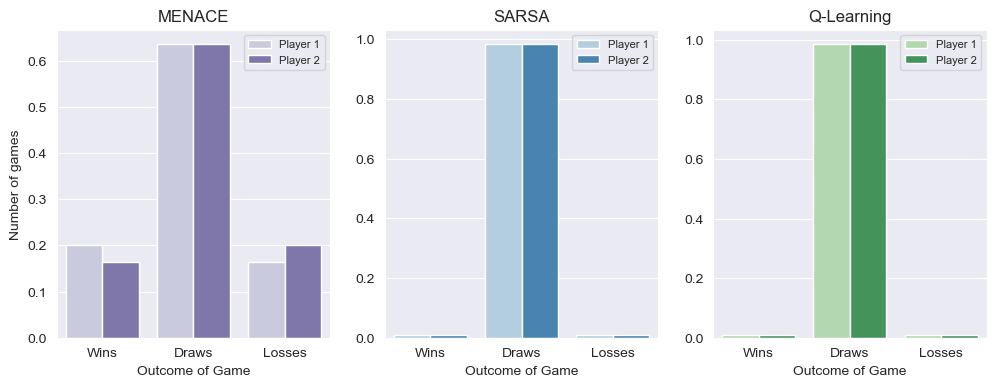

In [119]:
_, ax = plt.subplots(1,3, figsize=(12, 4))
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_menace_board4_trained, palette='Purples', ax = ax[0])
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_sarsa_board4_trained, palette='Blues', ax = ax[1])
sns.barplot(x='Outcome', y='Proportion of games', hue='Player', data=df_q_board4_trained, palette='Greens', ax = ax[2])


ax[0].set_title('MENACE')
ax[1].set_title('SARSA')
ax[2].set_title('Q-Learning')
ax[0].set_ylabel('Number of games', fontsize = 10)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[0].set_xlabel('Outcome of Game', fontsize = 10)
ax[1].set_xlabel('Outcome of Game', fontsize = 10)
ax[2].set_xlabel('Outcome of Game', fontsize = 10)
ax[0].legend(title=None, fontsize = 8)
ax[1].legend(title=None, fontsize = 8)
ax[2].legend(title=None, fontsize = 8)

    
plt.show()

For the `4x4` board, we can rank the three methods in terms of performace and effectiveness of learning the optimal policy as follows:
1. Q-Learning (just under `99%`)
2. SARSA (just under `99%`)
3. MENACE (just under `65%`)

Interestingly, this order is the opposite of the performance ranking for the `3x3` board. The potential reasoning behind these results is discussed in detail in the "Discussion" section below.

### Plotting computational time for MENACE, SARSA, and Q-Learning

#### 3x3 board

To make a fair comparison, we train each pair of players (for each respective method) with the same arguments (`1,000,000` games, `draw_reqs = True`, and `draw_threshold = 0.7`). Here, we use the command `%%capture` to silence the output of the cell since we do not require the details of the training.

In [395]:
%%capture

starting_time_menace = time.time()

train_menace('board3', 1000000, draw_reqs = True, draw_threshold = 0.7)

finishing_time_menace = time.time()
total_time_taken_menace = finishing_time_menace - starting_time_menace



starting_time_sarsa = time.time()

train_sarsa('board3', 1000000, draw_reqs = True, draw_threshold = 0.7)

finishing_time_sarsa = time.time()
total_time_taken_sarsa = finishing_time_sarsa - starting_time_sarsa



starting_time_qlearning = time.time()

train_q('board3', 1000000, draw_reqs = True, draw_threshold = 0.7)

finishing_time_qlearning = time.time()
total_time_taken_qlearning = finishing_time_qlearning - starting_time_qlearning

We can now plot a bar chart to compare the total computational time for each method.

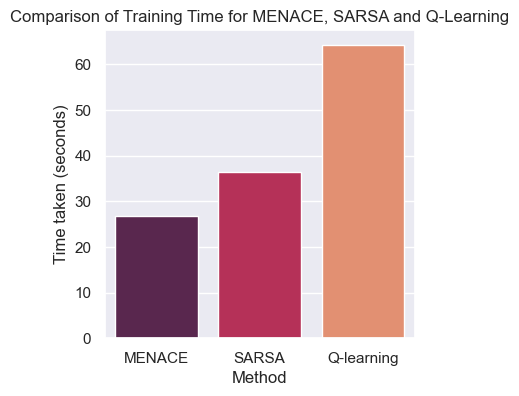

In [396]:
methods = ['MENACE','SARSA', 'Q-learning']
time_value = [total_time_taken_menace, total_time_taken_sarsa, total_time_taken_qlearning]

plt.figure(figsize=(4, 4))
ax = sns.barplot(x = methods, y = time_value, palette='rocket')
plt.xlabel('Method')
plt.ylabel('Time taken (seconds)')
plt.title('Comparison of Training Time for MENACE, SARSA and Q-Learning (3x3 board)')
plt.show()

For the `3x3` board, we can see that the `MenacePlayer` objects are trained the fastest, while the `QLearningPlayer` objects take the longest. This makes sense because the *Q-Learning* algorithm has the most complicated formula for iteratively updating the rewards/q-values among the three methods, while MENACE is the simplest.

These results further back up the performance ranking for the `3x3` board. 

We can conclude that, for the `3x3` board, MENACE is the best algorithm, both in terms of effectiveness of learning the optimal policy, and time complexity.

#### 4x4 board

We repeat the steps from above.

In [133]:
%%capture

starting_time_menace_b4 = time.time()

train_menace('board4', 1000000, draw_reqs = False)

finishing_time_menace_b4 = time.time()
total_time_taken_menace_b4 = finishing_time_menace_b4 - starting_time_menace_b4



starting_time_sarsa_b4 = time.time()

train_sarsa('board4', 1000000, draw_reqs = False)

finishing_time_sarsa_b4 = time.time()
total_time_taken_sarsa_b4 = finishing_time_sarsa_b4 - starting_time_sarsa_b4



starting_time_qlearning_b4 = time.time()

train_q('board4', 1000000, draw_reqs = False)

finishing_time_qlearning_b4 = time.time()
total_time_taken_qlearning_b4 = finishing_time_qlearning_b4 - starting_time_qlearning_b4

We can now plot the bar chart.

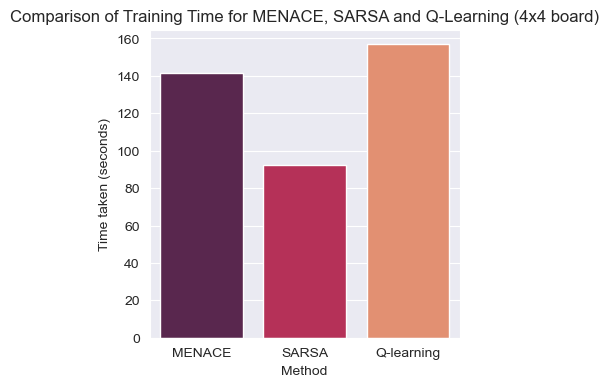

In [134]:
methods = ['MENACE','SARSA', 'Q-learning']
time_value = [total_time_taken_menace_b4, total_time_taken_sarsa_b4, total_time_taken_qlearning_b4]

plt.figure(figsize=(4, 4))
ax = sns.barplot(x = methods, y = time_value, palette='rocket')
plt.xlabel('Method')
plt.ylabel('Time taken (seconds)')
plt.title('Comparison of Training Time for MENACE, SARSA and Q-Learning (4x4 board)')
plt.show()

For the `4x4` board, we can see that the *Q-Learning* algorithm takes the longest to train, followed by MENACE. *SARSA* takes the least amount of time to train. 

Since the performance of MENACE was already quite poor compared to *SARSA* and *Q-Learning*, we choose not to consider that method for the `4x4` board. Here, we want to compare between *SARSA* and *Q-Learning*. 

Since the draw rates of both these methods were almost the same (both about `98%`), now the computational time is an ideal property to consider. As the time taken to train the `SARSAPlayer` objects is significantly less than the time taken to train the `QLearningPlayer` objects, we can conclude that using the *SARSA* algorithm for the `4x4` board may be most feasable. 

## Conclusion

#### Objective and Final Findings

In this project, we proposed three methods to play a game of Tic-Tac-Toe (also known as Noughts and crosses) optimally- Donald Michie’s MENACE, and two widely used reinforcement learning algorithms, *SARSA* and *Q-Learning*. Here, an optimal game is a game which ends in a forced draw. For this project, we explored the regular `3x3` board and also extended it to a `4x4` board. We began by creating players for each method and training them such that they reach the maximum possible optimality. We assessed each algorithm’s performance by comparing the final draw rates achieved after training. We also compared the computational time for each method.

For a `3x3` board, we found that the `MenacePlayer` objects perform the best, with a draw rate of about `99%`. This is almost perfectly optimal. In comparison, the `SARSAPlayer` and `QLearningPlayer` objects are much less optimal, both with a draw rate of about `65%`. This is backed up by the computational times, which suggests that training MENACE is the quickest, followed by *SARSA* and then lastly, *Q-Learning*. As MENACE achieves the highest (and almost perfect) draw rate and the lowest computational time, it is suggested that Donald Michie’s MENACE is the best learning algorithm for a `3x3` board. This could be due to the small environment space of a `3x3` board, where MENACE’s brute force via trial and error in exploring every single state is far more robust than the other more complex algorithms.

In contrast, for the `4x4` board, we find that both the `SARSAPlayer` and `QLearningPlayer` objects perform much better than the `MenacePlayer` objects. *SARSA* and *Q-Learning* both reach draw rates of about `98%`, while MENACE reaches a draw rate of only about `64%`. Theoretically and technically, MENACE just like the `3x3` board could increase its draw rate to near optimal. However, due to the now large environment space of a `4x4` board, MENACE takes quite a long time to train. In comparison, *SARSA* takes the least amount of time, so we conclude that this might be the most computationally feasible. However, the *SARSA* and *Q-Learning* algorithms have their own flaws as discussed below.

#### Why SARSA and Q-learning may perform better on a 4x4 board compared to a 3x3 board?

One reason could be that a `4x4` board simply is larger and more complex than a `3x3` board, with `16` positions compared to just `9`. Because of this, a `4x4` board has more winning combinations. This increased complexity may provide a more difficult challenge for the learning algorithms, which may result in more robust learning and better performance overall.

Another reason could be that *SARSA* and *Q-learning* rely on the exploration-exploitation tradeoff to balance between trying new moves and exploiting learned knowledge to maximise reward. With the `4x4` board being larger as mentioned, there are more opportunities for exploration and larger state space, which may allow the algorithms to explore more and learn a better policy.

However, as there are so many different factors, it is difficult to pinpoint the single reason why these algorithms perform better on a `4x4` board.

#### On a 4x4 board, why do SARSA and Q-learning have such a high draw rate (about 98%), but still lose to a human player?

A reason for this may be overfitting to a specific training environment. This is similar to overfitting a machine learning model, causing it to learn the training set very well, but perform poorly on a newly introduced test set.

While training, the *SARSA* and *Q-Learning* players train in a very specific environment and against very specific opponents (players of their own type).  This means that they learn to play optimally against each other. However, a human player, or even a player trained using a different algorithm, may not play with the same strategy and tactics as their own. Hence, their learnt strategy may not work too well against a different opponent. 

#### Final Conclusion

Due to the above discussions on the flaws of *SARSA* and *Q-Learning*’s performances on the `4x4` board, we conclude that overall, Donald Michie’s original MENACE algorithm stands superior, more reliable, more robust, and ultimately more preferred compared to the other two algorithms.

#### What could be explored further?

In the future, we could experiment with even more dimension sizes of tic-tac-toe boards, starting with a `5x5`. We could also extend the dimensions and explore a 3-dimensional version of the game, where it is a `3x3x3`, with the existing `3x3` rules. Perhaps by increasing the dimension sizes and environment spaces, *SARSA* and *Q-Learning* could replace MENACE as the preferred algorithm.

In addition, we could experiment with different ways in rewarding MENACE, i.e. adding or removing a different number of beads for each outcome of the game. This may result in a completely different training time.

Moreover, we could also explore the effectiveness of *SARSA* and *Q-Learning* algorithms on the `4x4` board further by diversifying the training environment. This could be done by having the *SARSA* and *Q-Learning* players train by playing against opponents of different algorithms, or even human opponents. Perhaps playing against opponents of different types may cause the players to become more robust. *Imitation Learning* can also be used, where the players would observe human players and train by mimicking their actions.

Finally, we could experiment with other reinforcement learning algorithms, such as *Monte Carlo Tree Search (MCTS)*. We could also implement deep learning by creating neural networks and using deep learning algorithms such as *Convolutional Neural Networks (CNN)* and *Deep Q-Networks (DQN)*.

## References

1. Donald Michie, Experiments on the Mechanization of Game-Learning Part I. Characterization of the Model and its parameters, The Computer Journal, Volume 6, Issue 3, November 1963, Pages 232–236, https://doi.org/10.1093/comjnl/6.3.232
2. Andrew McCarthy, Menace, 2017, GitHub repository, https://github.com/andrewmccarthy/menace
3. Marcello Cammarata, http://people.missouristate.edu/lesreid/sol10_04.html (Webpage by Les Reid)
4. Sayak Paul, An introduction to Q-Learning: Reinforcement Learning, 15 May 2019, https://blog.floydhub.com/an-introduction-to-q-learning-reinforcement-learning/